# find overlap and difference between eQTL signals in genes and isoforms

In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )


In [2]:
geneinfo_genes    = fread("pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoforms = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)


In [3]:
eqtl_genes       = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egenes.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
eqtl_isoforms0    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egenes.txt"  , sep = "\t", header = TRUE, data.table = FALSE)
#eqtl_genes       = eqtl_genes   [eqtl_genes   $egene == TRUE,]
eqtl_isoforms    = eqtl_isoforms0[eqtl_isoforms0$egene == TRUE,]


In [4]:
ints_genes       = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.interactions.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
ints_isoforms    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.interactions.txt"  , sep = "\t", header = TRUE, data.table = FALSE)

ints_genes       = ints_genes   [ints_genes   $int_signif == TRUE,]
ints_isoforms    = ints_isoforms[ints_isoforms$int_signif == TRUE,]

In [5]:
gene2int = aggregate(interaction ~ transcript_id + gene_name, data = ints_genes   [ints_genes   $int_signif == TRUE,], FUN = function(x){paste(sort(unique(x)), collapse = "; ")})
iso2int  = aggregate(interaction ~ transcript_id + gene_name, data = ints_isoforms[ints_isoforms$int_signif == TRUE,], FUN = function(x){paste(sort(unique(x)), collapse = "; ")})


In [6]:
coloc = fread("pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
coloc = merge(coloc, geneinfo_isoforms[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by.x = "transcript_id1", by.y = "transcript_id")

# Agreement between eGenes and eIsoforms
## How many eGenes have eIsoforms?

In [7]:
message(paste("eGenes"               , length(                                               unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]) ), sep = " = "))
message(paste("Genes with eIsoforms" , length(          unique(eqtl_isoforms$gene_id      )                                                          ), sep = " = "))
message(paste("eIsoforms"            , length(          unique(eqtl_isoforms$transcript_id)                                                          ), sep = " = "))
message(paste("eGenes with eIsoforms", length(intersect(unique(eqtl_isoforms$gene_id      ), unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]))), sep = " = "))

message(paste("eIsoforms associated with eGenes", length(unique(coloc[coloc$transcript_id1 %in% unique(eqtl_isoforms$transcript_id) & coloc$transcript_id2 %in% unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]), "transcript_id1"])), sep = " = "))

message(paste("eIsoforms not associated with eGenes = ", 
              length(unique(eqtl_isoforms[!eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "transcript_id"])), 
              " (",
              signif(length(unique(eqtl_isoforms[!eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "transcript_id"]))/length(unique(eqtl_isoforms$transcript_id)) * 100, digits = 3), 
              "%, ",
              length(unique(eqtl_isoforms[!eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "gene_id"])),
              " genes)",
              sep = ""))



eGenes = 11692

Genes with eIsoforms = 3847

eIsoforms = 7165

eGenes with eIsoforms = 2909

eIsoforms associated with eGenes = 5744

eIsoforms not associated with eGenes = 1421 (19.8%, 938 genes)



## How many eIsoforms do not colocalize with their associated gene?

In [8]:
totest = coloc[coloc$transcript_id1 %in% unique(eqtl_isoforms$transcript_id) & coloc$transcript_id2 %in% unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]),]
totest = aggregate(PP.H4.abf ~ transcript_id1 + transcript_id2 + gene_id + gene_name + gene_type, data = totest, FUN = max)

fwrite(totest, "pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.iso2gene.pph4_max.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [9]:
message(paste("eIsoforms that do not colocalize with eGenes = ", 
              nrow(totest[totest$PP.H4.abf < 0.5, ]), 
              " (",
              signif(nrow(totest[totest$PP.H4.abf < 0.5, ]) / nrow(totest) * 100, digits = 3),
              "%)",
              sep = ""))


message(paste("eIsoforms that have different signals than genes = ", 
              nrow(totest[totest$PP.H4.abf < 0.5, ]) + length(unique(eqtl_isoforms[!eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "transcript_id"])), 
              " (",
              signif((nrow(totest[totest$PP.H4.abf < 0.5, ]) + length(unique(eqtl_isoforms[!eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "transcript_id"]))) / length(unique(eqtl_isoforms$transcript_id)) * 100, digits = 3),
              "%)",
              sep = ""))


eIsoforms that do not colocalize with eGenes = 2650 (46.1%)

eIsoforms that have different signals than genes = 4071 (56.8%)



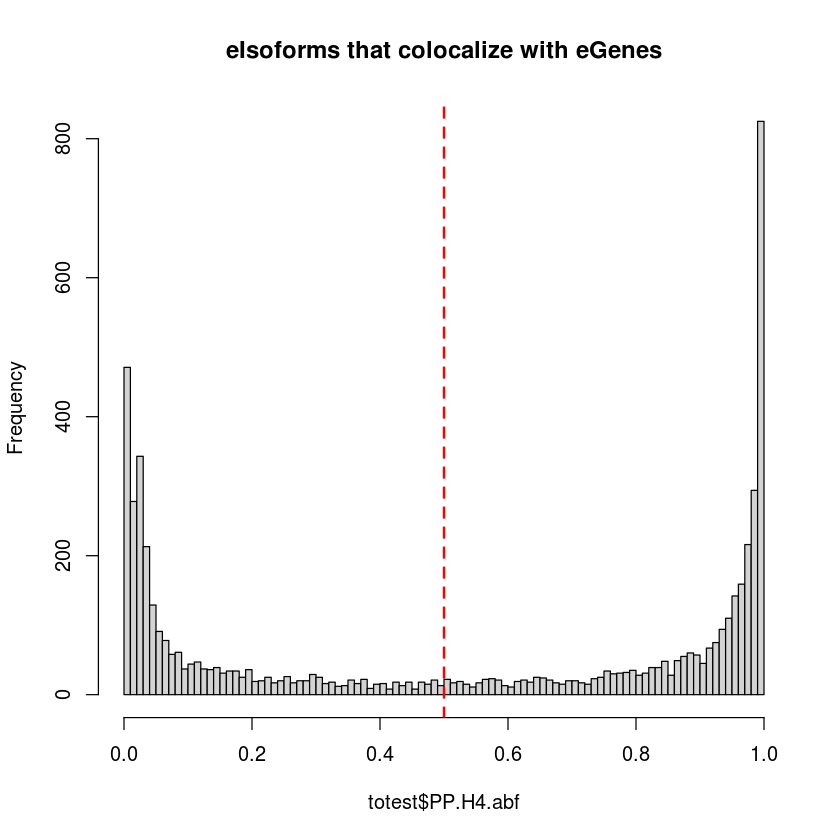

In [10]:
hist(totest$PP.H4.abf, breaks = (0:100) / 100, main = "eIsoforms that colocalize with eGenes")
abline(v = 0.5, lty = "dashed", col = "#ff0000", lwd = 2)

## Of the eIsoforms that colocalize with eGenes, how many agree with tissue/cell type?

In [11]:
tocell = coloc [coloc $transcript_id1 %in% unique(eqtl_isoforms$transcript_id) & coloc$transcript_id2 %in% unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]),]

tocell = as.data.frame(rbindlist(lapply(sort(unique(tocell$transcript_id1)), function(x)
{
    this = tocell[tocell$transcript_id1 == x,]
    this = this  [which.max(this$PP.H4.abf),]
    
    return(this)
})), stringsAsFactors = FALSE)

tocell = cbind(tocell, as.data.frame(rbindlist(lapply(1:nrow(tocell), function(ii)
{
    transcript_id = tocell[ii, "transcript_id1"]
    gene_id       = tocell[ii, "gene_id"       ]
    type1         = tocell[ii, "type1"         ]
    type2         = tocell[ii, "type2"         ]

    int1 = ints_isoforms[ints_isoforms$transcript_id == transcript_id & ints_isoforms$type == type1, "interaction"]
    int2 = ints_genes   [ints_genes   $gene_id       == gene_id       & ints_genes   $type == type2, "interaction"]
    
    int1_cell   = int1[grepl("cibersort", int1) == TRUE ]
    int2_cell   = int2[grepl("cibersort", int2) == TRUE ]
    int1_tissue = int1[grepl("cibersort", int1) == FALSE]
    int2_tissue = int2[grepl("cibersort", int2) == FALSE]

    out  = data.frame(overlap_cell   = paste(intersect(int1_cell  , int2_cell  ), collapse = "; "), 
                      only1_cell     = paste(setdiff  (int1_cell  , int2_cell  ), collapse = "; "), 
                      only2_cell     = paste(setdiff  (int2_cell  , int1_cell  ), collapse = "; "),
                      overlap_tissue = paste(intersect(int1_tissue, int2_tissue), collapse = "; "), 
                      only1_tissue   = paste(setdiff  (int1_tissue, int2_tissue), collapse = "; "), 
                      only2_tissue   = paste(setdiff  (int2_tissue, int1_tissue), collapse = "; "),
                      jaccard_cell   = length(intersect(int1_cell  , int2_cell  )) / length(unique(c(int1_cell  , int2_cell  ))),
                      jaccard_tissue = length(intersect(int1_tissue, int2_tissue)) / length(unique(c(int1_tissue, int2_tissue)))
                     )
    
    return(out)
})), stringsAsFactors = FALSE))

tocell$is_overlap_cell   = FALSE
tocell$is_only1_cell     = FALSE
tocell$is_only2_cell     = FALSE
tocell$is_overlap_tissue = FALSE
tocell$is_only1_tissue   = FALSE
tocell$is_only2_tissue   = FALSE

tocell[tocell$overlap_cell   != "", "is_overlap_cell"  ] = TRUE
tocell[tocell$only1_cell     != "", "is_only1_cell"    ] = TRUE
tocell[tocell$only2_cell     != "", "is_only2_cell"    ] = TRUE
tocell[tocell$overlap_tissue != "", "is_overlap_tissue"] = TRUE
tocell[tocell$only1_tissue   != "", "is_only1_tissue"  ] = TRUE
tocell[tocell$only2_tissue   != "", "is_only2_tissue"  ] = TRUE

fwrite(tocell, "pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.iso2gene.cell_type_differences.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [12]:
cor.test(tocell[is.na(tocell$jaccard_cell  ) == FALSE, "jaccard_cell"  ], tocell[is.na(tocell$jaccard_cell  ) == FALSE, "PP.H4.abf"])
cor.test(tocell[is.na(tocell$jaccard_tissue) == FALSE, "jaccard_tissue"], tocell[is.na(tocell$jaccard_tissue) == FALSE, "PP.H4.abf"])

#summary(lm(PP.H4.abf ~ jaccard_cell  , data = tocell[is.na(tocell$jaccard_cell  ) == FALSE,]))
#summary(lm(PP.H4.abf ~ jaccard_tissue, data = tocell[is.na(tocell$jaccard_tissue) == FALSE,]))
#
#
#boxplot(PP.H4.abf ~ jaccard_cell  , data = tocell[is.na(tocell$jaccard_cell  ) == FALSE,])
#boxplot(PP.H4.abf ~ jaccard_tissue, data = tocell[is.na(tocell$jaccard_tissue) == FALSE,])
#


	Pearson's product-moment correlation

data:  tocell[is.na(tocell$jaccard_cell) == FALSE, "jaccard_cell"] and tocell[is.na(tocell$jaccard_cell) == FALSE, "PP.H4.abf"]
t = 5.4028, df = 1505, p-value = 7.616e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.08805467 0.18712940
sample estimates:
      cor 
0.1379371 



	Pearson's product-moment correlation

data:  tocell[is.na(tocell$jaccard_tissue) == FALSE, "jaccard_tissue"] and tocell[is.na(tocell$jaccard_tissue) == FALSE, "PP.H4.abf"]
t = 6.0545, df = 1479, p-value = 1.783e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1054151 0.2048317
sample estimates:
      cor 
0.1555172 



FALSE  TRUE 
 2650  3094 

         is_coloc
int_cell  FALSE TRUE
           2092 2194
  only1      58  110
  only2     488  696
  overlap    12   94

          is_coloc
int_tissue FALSE TRUE
            2203 2114
   only1     107  145
   only2     324  682
   overlap    16  153


          only1   only2 overlap 
   4286     168    1184     106 


          only1   only2 overlap 
   4317     252    1006     169 

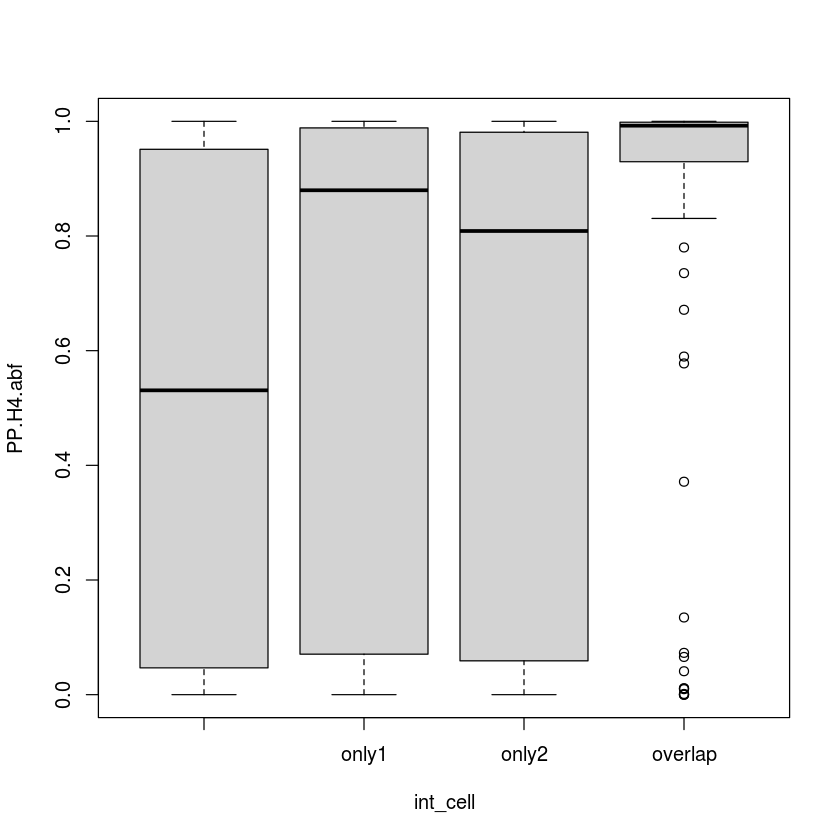

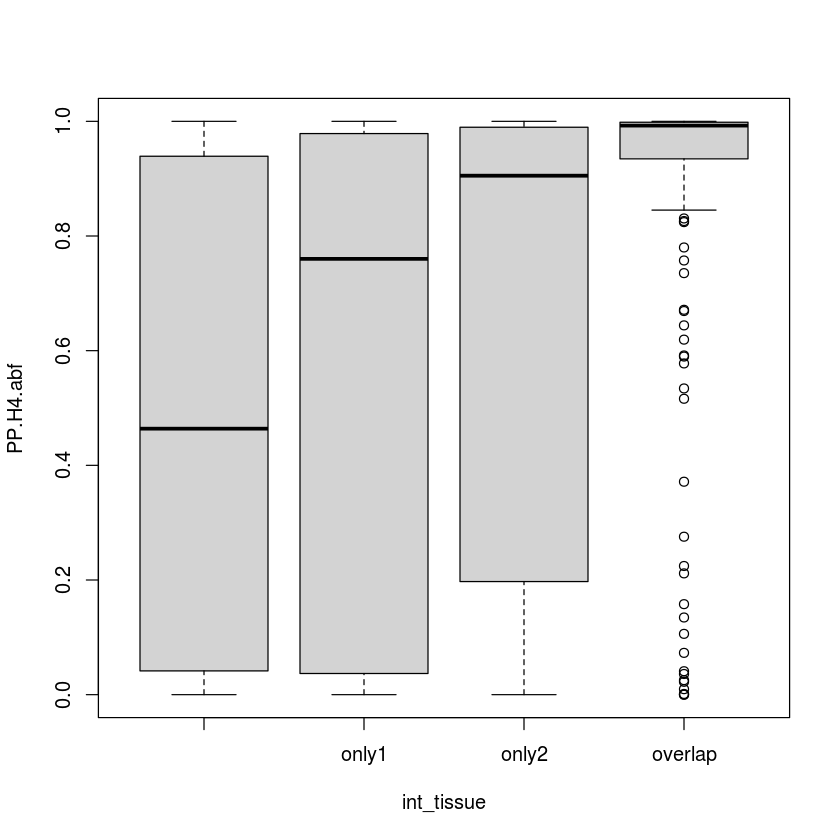

In [13]:
tocell$int_cell   = ""
tocell$int_tissue = ""
tocell[tocell$is_overlap_cell   == TRUE, "int_cell"] = "overlap"
tocell[tocell$is_overlap_cell   == FALSE & tocell$is_only1_cell   == TRUE  & tocell$is_only2_cell   == FALSE, "int_cell"] = "only1"
tocell[tocell$is_overlap_cell   == FALSE & tocell$is_only1_cell   == FALSE & tocell$is_only2_cell   == TRUE , "int_cell"] = "only2"
tocell[tocell$is_overlap_tissue == TRUE, "int_tissue"] = "overlap"
tocell[tocell$is_overlap_tissue == FALSE & tocell$is_only1_tissue == TRUE  & tocell$is_only2_tissue == FALSE, "int_tissue"] = "only1"
tocell[tocell$is_overlap_tissue == FALSE & tocell$is_only1_tissue == FALSE & tocell$is_only2_tissue == TRUE , "int_tissue"] = "only2"

tocell$is_coloc = FALSE

tocell[tocell$PP.H4.abf > 0.5, "is_coloc"] = TRUE

table(tocell$is_coloc)

table(tocell[,c("int_cell"  , "is_coloc")])
table(tocell[,c("int_tissue", "is_coloc")])

table(tocell$int_cell)
table(tocell$int_tissue)

boxplot(PP.H4.abf ~ int_cell  , data = tocell)
boxplot(PP.H4.abf ~ int_tissue, data = tocell)


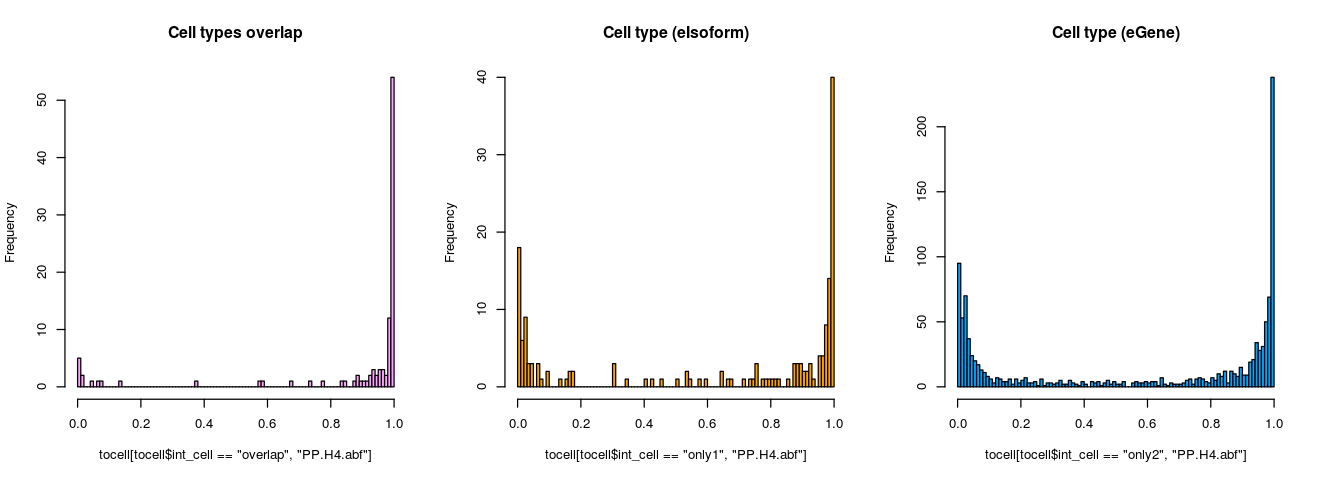

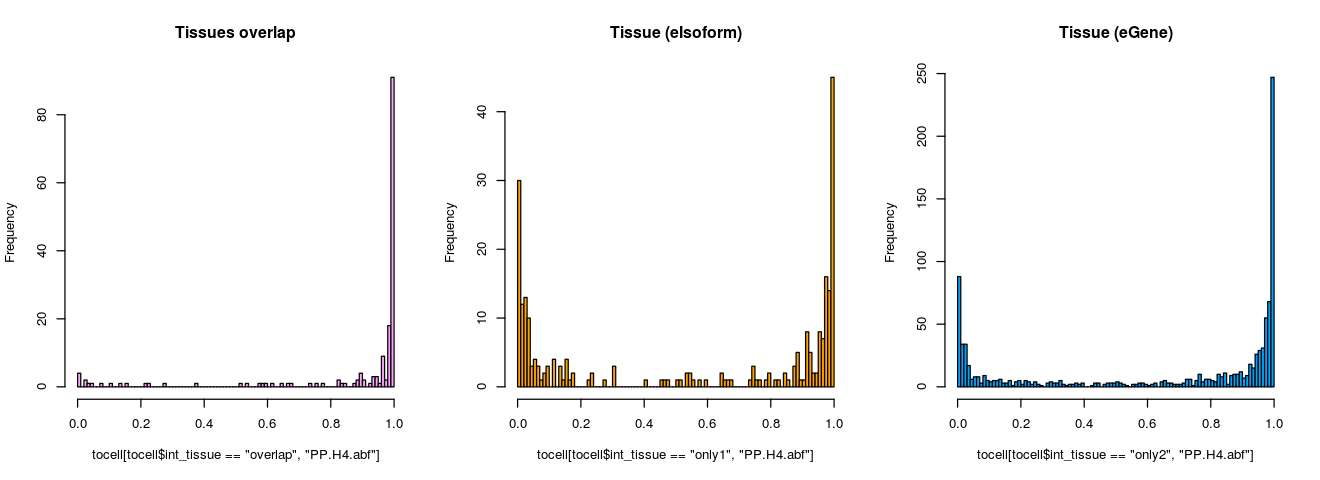

In [14]:
options(repr.plot.width = 11, repr.plot.height = 4)
layout(rbind(1:3))

hist(tocell[tocell$int_cell   == "overlap", "PP.H4.abf"], breaks = (0:100) / 100, col = "#ffa5ff", main = "Cell types overlap")
hist(tocell[tocell$int_cell   == "only1"  , "PP.H4.abf"], breaks = (0:100) / 100, col = "#ffa500", main = "Cell type (eIsoform)")
hist(tocell[tocell$int_cell   == "only2"  , "PP.H4.abf"], breaks = (0:100) / 100, col = "#00a5ff", main = "Cell type (eGene)")
hist(tocell[tocell$int_tissue == "overlap", "PP.H4.abf"], breaks = (0:100) / 100, col = "#ffa5ff", main = "Tissues overlap")
hist(tocell[tocell$int_tissue == "only1"  , "PP.H4.abf"], breaks = (0:100) / 100, col = "#ffa500", main = "Tissue (eIsoform)")
hist(tocell[tocell$int_tissue == "only2"  , "PP.H4.abf"], breaks = (0:100) / 100, col = "#00a5ff", main = "Tissue (eGene)")



In [15]:
nrow(tocell)
nrow(tocell[tocell$overlap_cell != "",])
nrow(tocell[tocell$overlap_cell == "" & tocell$only1_cell != "" & tocell$only2_cell == "",])
nrow(tocell[tocell$overlap_cell == "" & tocell$only1_cell == "" & tocell$only2_cell != "",])
nrow(tocell[tocell$overlap_tissue != "",])
nrow(tocell[tocell$overlap_tissue == "" & tocell$only1_tissue != "" & tocell$only2_tissue == "",])
nrow(tocell[tocell$overlap_tissue == "" & tocell$only1_tissue == "" & tocell$only2_tissue != "",])


[1] 5744

[1] 106

[1] 168

[1] 1184

[1] 169

[1] 252

[1] 1006

In [17]:
fwrite(tocell, "pipeline/3.2.eqtls/eqtl_overlap/integrate_egene_eisoform_cell_coloc.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [16]:
str(tocell)

'data.frame':	5744 obs. of  39 variables:
 $ transcript_id1   : chr  "ENST00000000412.3" "ENST00000002125.9_2" "ENST00000003302.8_2" "ENST00000003583.12_2" ...
 $ nsnps            : int  2061 2034 2104 1957 2724 2272 1669 1881 2320 2629 ...
 $ PP.H0.abf        : num  5.85e-37 1.03e-09 2.94e-05 6.75e-64 1.90e-10 ...
 $ PP.H1.abf        : num  1.34e-29 3.10e-01 4.77e-01 8.89e-14 8.99e-03 ...
 $ PP.H2.abf        : num  2.01e-09 1.88e-09 3.09e-05 7.59e-51 1.70e-09 ...
 $ PP.H3.abf        : num  0.0451 0.5663 0.5019 1 0.0793 ...
 $ PP.H4.abf        : num  9.55e-01 1.24e-01 2.13e-02 9.55e-15 9.12e-01 ...
 $ transcript_id2   : chr  "ENSG00000003056.3" "ENSG00000003509.16_5" "ENSG00000048028.11_6" "ENSG00000001460.18_7" ...
 $ type1            : int  1 0 0 0 0 0 0 0 0 0 ...
 $ type2            : int  0 0 0 0 2 0 0 1 0 0 ...
 $ id               : chr  "VAR_12_9084931_G_A" "VAR_2_37480249_A_G" "VAR_11_113741466_T_C" "VAR_1_24731737_C_T" ...
 $ af               : num  0.438 0.32 0.435 0.31 0.264 

# Look at some examples

In [23]:
ints_genes       = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.interactions.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
ints_isoforms    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.interactions.txt"  , sep = "\t", header = TRUE, data.table = FALSE)


In [24]:
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(colorspace))


In [25]:
toplot = table(totest$gene_id)
#toplot = names(toplot[toplot %in% c(4,5)])
toplot = names(toplot)


In [26]:
net_iso = function(gene_id, coloc, eqtl_genes, eqtl_isoforms)
{
    eqtl_genes         = eqtl_genes   [eqtl_genes   $gene_id == gene_id,]
    eqtl_isoforms      = eqtl_isoforms[eqtl_isoforms$gene_id == gene_id,]
    vertices_gene      = aggregate(list(pval = eqtl_genes   $pval, fdr = eqtl_genes   $fdr), by = list(transcript_id = eqtl_genes   $transcript_id), FUN = min)
    vertices_isoform   = aggregate(list(pval = eqtl_isoforms$pval, fdr = eqtl_isoforms$fdr), by = list(transcript_id = eqtl_isoforms$transcript_id), FUN = min)
    vertices_gene$x    = "gene"
    vertices_isoform$x = "isoform"
    vertices           = rbind(vertices_gene, vertices_isoform)
    vertices$color     = "#cccccc"
    vertices$color_t   = "#880000"
    vertices[vertices$fdr <= 0.05  , "color"  ] = "#ffff00"
    vertices[vertices$x   == "gene", "color_t"] = "#000088"
    
    edges              = coloc[coloc$gene_id == gene_id, c("transcript_id1", "transcript_id2", "pp_snp", "PP.H4.abf", "PP.H3.abf", "type1", "type2")]
    edges$color_edge   = "#cccccc"
    
    edges[rowSums(edges[,c("type1", "type2")]) == 0, "color_edge"] = "#7dc0f5"
    edges[edges$type1 == 0 & edges$type2 == 1      , "color_edge"] = "#f8a29f"
    edges[edges$type1 == 1 & edges$type2 == 0      , "color_edge"] = "#713430"
    edges[edges$type1 == 1 & edges$type2 == 1      , "color_edge"] = "#004b74"
    edges[edges$type1 >  1 & edges$type2 >  1      , "color_edge"] = "#777777"
    
    edges = edges[order(rowSums(edges[,c("type1", "type2")])),]
    
    net_gene       = graph_from_data_frame(d        = edges, 
                                           vertices = vertices, 
                                           directed = FALSE)
    
    plot(net_gene, 
         layout             = layout.fruchterman.reingold(net_gene), 
         edge.width         = (E(net_gene)$PP.H4.abf - E(net_gene)$PP.H3.abf) / max((E(net_gene)$PP.H4.abf - E(net_gene)$PP.H3.abf)) * 20, 
         edge.color         = E(net_gene)$color_edge, 
         vertex.shape       = "circle", 
         vertex.label.color = V(net_gene)$color_t, 
         vertex.color       = V(net_gene)$color, 
         vertex.label.font  = 3,
         main               = unique(eqtl_genes$gene_name)
        )
    
}

options(repr.plot.width = 8.5, repr.plot.height = 8.5)

pdf(file = "pipeline/3.2.eqtls/TMP.isoform_vs_gene.pdf", width = 8.5, height = 8.5)
invisible(lapply(toplot, function(gene_id){try(net_iso(gene_id, coloc, eqtl_genes, eqtl_isoforms))}))

dev.off()
#net_iso("ENSG00000119684.15_5", coloc, eqtl_genes, eqtl_isoforms)
#net_iso("ENSG00000225241.3"   , coloc, eqtl_genes, eqtl_isoforms) # did not work: why?
#net_iso("ENSG00000092094.11_6", coloc, eqtl_genes, eqtl_isoforms)
#net_iso("ENSG00000110628.16_8", coloc, eqtl_genes, eqtl_isoforms)
#net_iso("ENSG00000104731.14_7", coloc, eqtl_genes, eqtl_isoforms)
#net_iso("ENSG00000101191.17_5", coloc, eqtl_genes, eqtl_isoforms)
#net_iso("ENSG00000153113.23_8", coloc, eqtl_genes, eqtl_isoforms)
#

Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...) : 
  no rows to aggregate
Error in aggregate.data.frame(as.data.frame(x), ...)

png 
  2

In [27]:
library(colorspace)

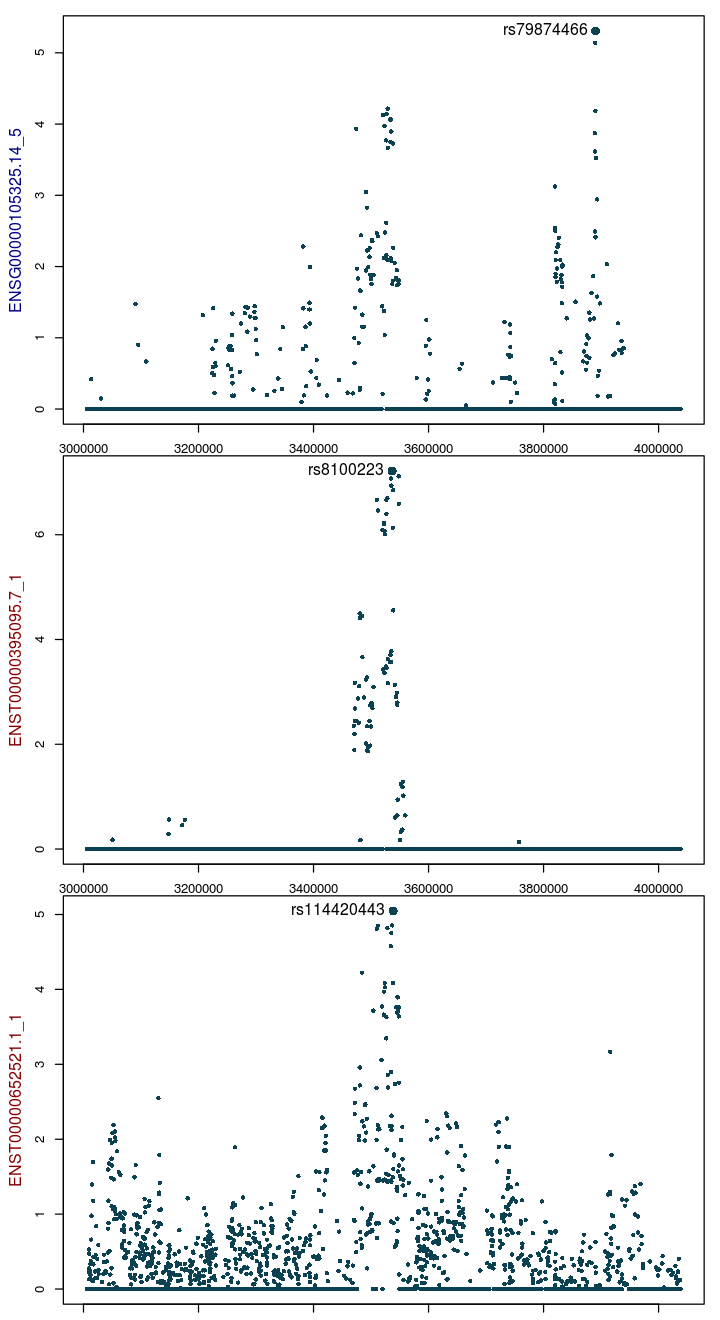

In [37]:
plot_signal = function(gene_id, eqtls, infolder)
{
    eqtl    = eqtls[ eqtls$egene == TRUE & eqtls$transcript_id == gene_id,]
    indata  = fread(paste(infolder , paste("qtl"    , gene_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    indata  = indata[indata$type %in% eqtl$type,]
    
    type2col = data.frame(type = 0:5, color = sequential_hcl(n = 6, palette = "Emrld"))
    indata   = merge(indata, type2col)
    indata   = indata[order(indata$type),]
    
    indata$cex = 0.75
    eqtl  $id2type = paste(eqtl  $id, eqtl  $type)
    indata$id2type = paste(indata$id, indata$type)
    
    indata[indata$id2type %in% eqtl$id2type, "cex"] = 1.5
    
    par(mar = c(1,4,1,1))
    plot(x = indata$pos, y = -log10(indata$pval), pch = 16, col = indata$color, cex = indata$cex, xlab = "", ylab = "")
    text(x = eqtl  $pos, y = -log10(eqtl  $pval), labels = eqtl$rsid, pos = 2, cex = 1.2)
    
    mycol = "#000088"
    if(grepl("^ENST", gene_id) == TRUE){mycol = "#880000"}
    
    mtext(text = gene_id, side = 2, line = 2.5, col = mycol, cex = 0.8)
}

plot_qtls_iso_vs_gene = function(gene_id, coloc, eqtl_genes, eqtl_isoforms)
{
    isoforms = unique(eqtl_isoforms[ eqtl_isoforms$gene_id == gene_id, "transcript_id"])
    
    
    options(repr.plot.width = 6, repr.plot.height = 11)
    tolayout = cbind(1:(length(isoforms) + 1))
    
    layout(tolayout)
    
    
    plot_signal(gene_id, eqtl_genes, "pipeline/3.2.eqtls/eqtls_by_gene/cardiac_eqtls.gene/")
    invisible(lapply(isoforms, function(x){plot_signal(x, eqtl_isoforms, "pipeline/3.2.eqtls/eqtls_by_gene/cardiac_eqtls.isoform/")}))
    
    
}

gene_names = c("CFH", "KLHDC4", "GCLC", "CFLAR", "CC2D2A", "M6PR", "NDUFAF7", "GCFC2", "SPATA20", "FARP2", "PIGQ", "ZNF200", "MVP", "NUB1", "DDX11",
               "B4GALT7", "VCL", "MED17", "MRPL43", "EIF4B", "HAGH", "TBC1D1", "REEP1", "POLR1A", "CLEC2D", "RORA", "ACTN1", "ACTN2", "LRCH4", "THOC1",
               "RAPGEF3", "PGS1", "PLEKHG2", "OSGEP", "MZF1", "CRYBB2P1", "DDX17", "EMC9", "GSS", "TRPC4AP", "SIRPB1", "ARHGEF7", "NME3", "TAF1C", 
               "CIAO3", "MTHFSD", "RBL2", "PDGFRL", "FZR1", "CPED1", "SLC22A18", "SOD2", "SPARC", "DROSHA", "RTN4", "CD46", "MLH3", "EPHX2", "OPTN",
               "STAU1", "PARP2", "NECTIN2"
              )

best = c("DDX17", "GSS", "TRPC4AP", "SIRPB1", "ARHGEF7", "CIAO3", "FZR1", "CPED1", "SOD2", "SPARC", "DROSHA", "CD46", "MLH3", "EPHX2", "OPTN", "STAU1",
         "NECTIN2"
        )

gene_names = c("DROSHA", "OPTN", "FZR1", "TRPC4AP")

gene_names = c("FZR1")
invisible(lapply(geneinfo_genes[geneinfo_genes$gene_name %in% gene_names, "gene_id"], function(gene_id){plot_qtls_iso_vs_gene(gene_id, coloc, eqtl_genes, eqtl_isoforms)}))
options(repr.plot.width = 8.5, repr.plot.height = 8.5)
#layout(rbind(c(1)))
#invisible(lapply(geneinfo_genes[geneinfo_genes$gene_name %in% gene_names, "gene_id"], function(gene_id){try(net_iso(gene_id, coloc, eqtl_genes, eqtl_isoforms))}))


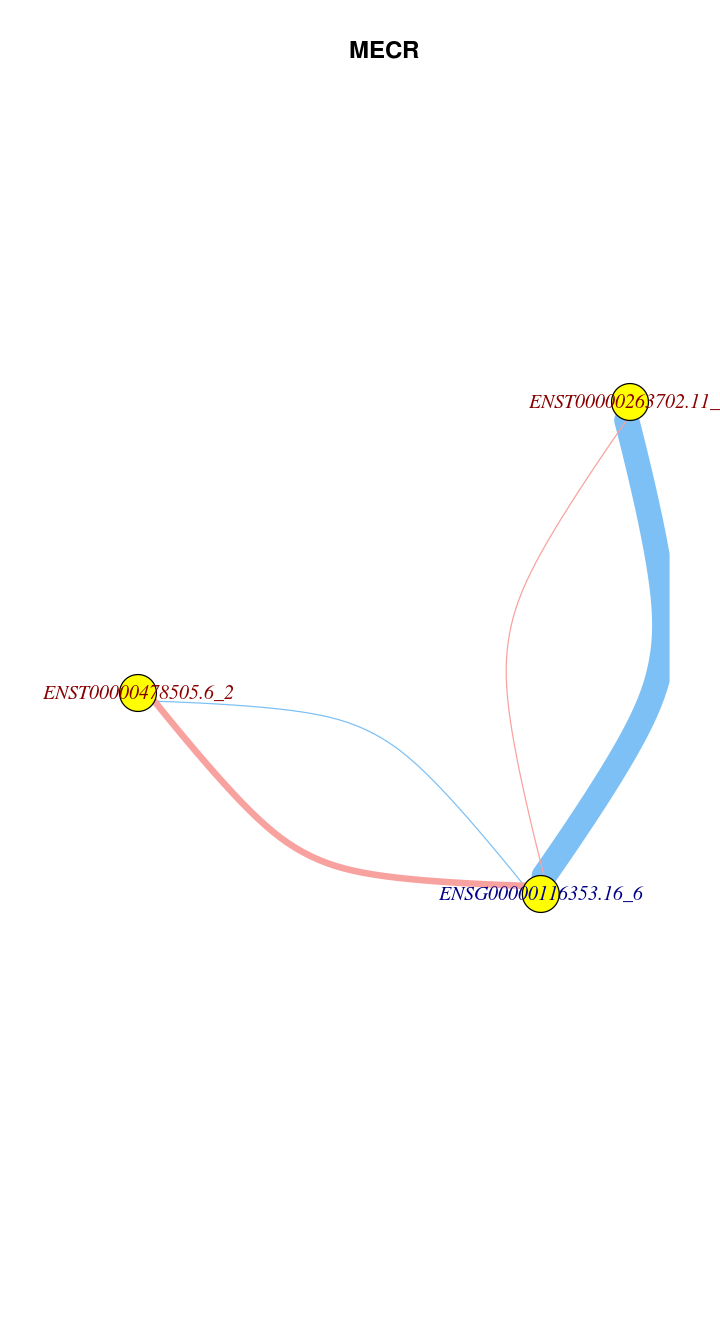

In [29]:
net_iso(geneinfo_genes[ geneinfo_genes$gene_name == "MECR", "gene_id"], coloc, eqtl_genes, eqtl_isoforms)

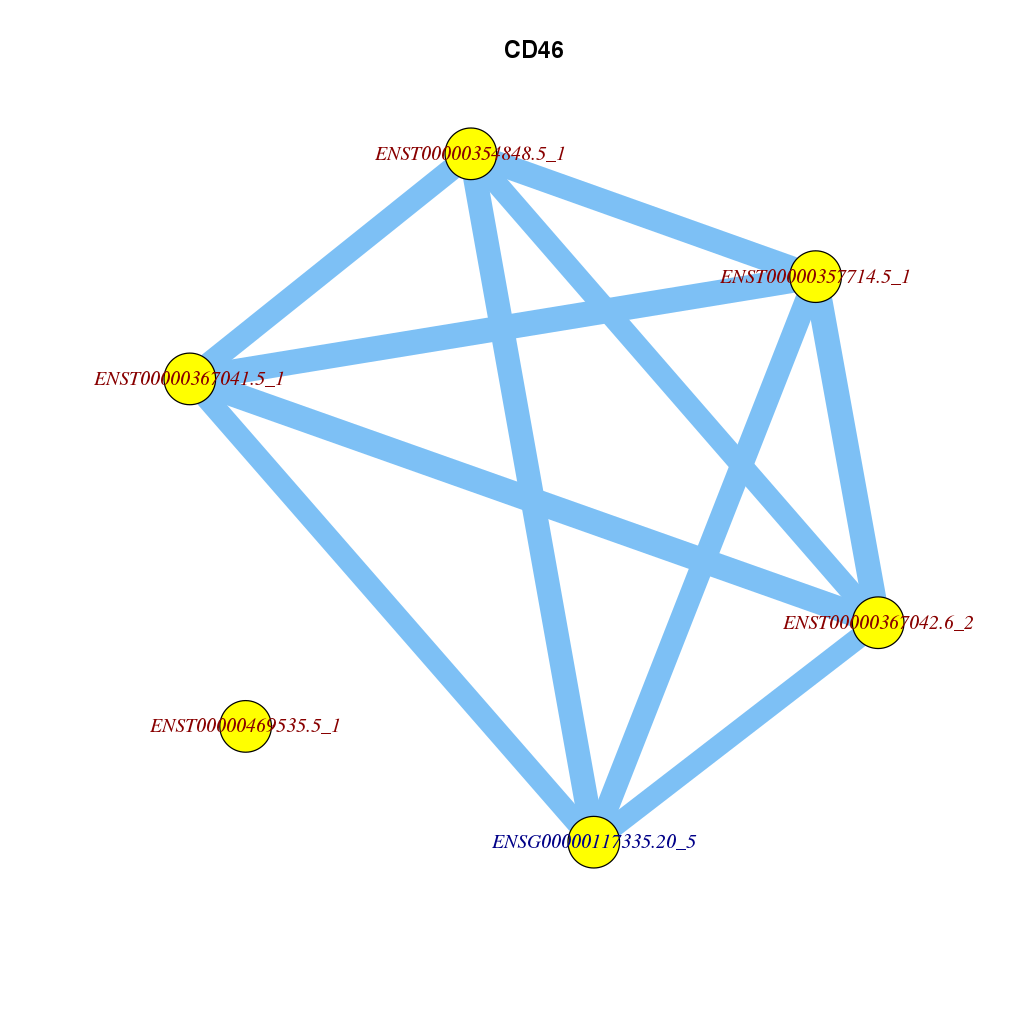

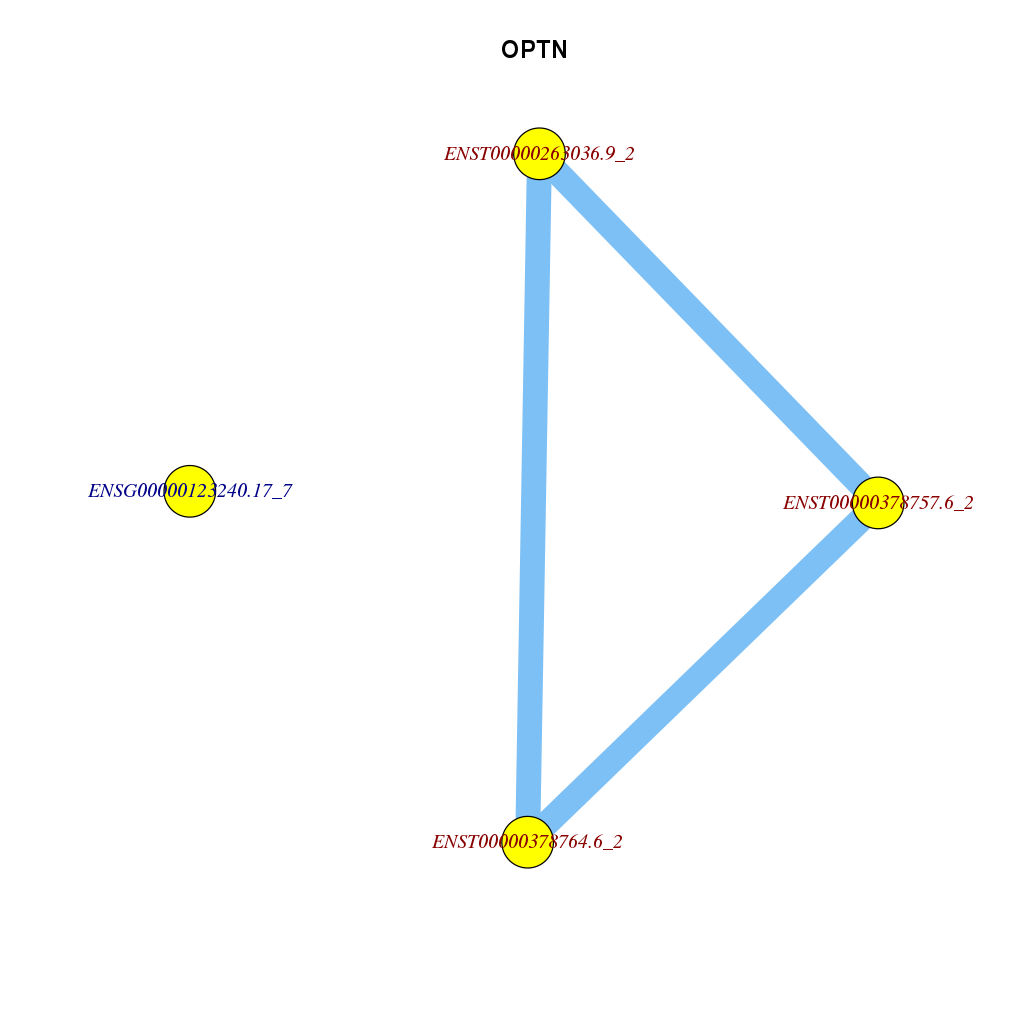

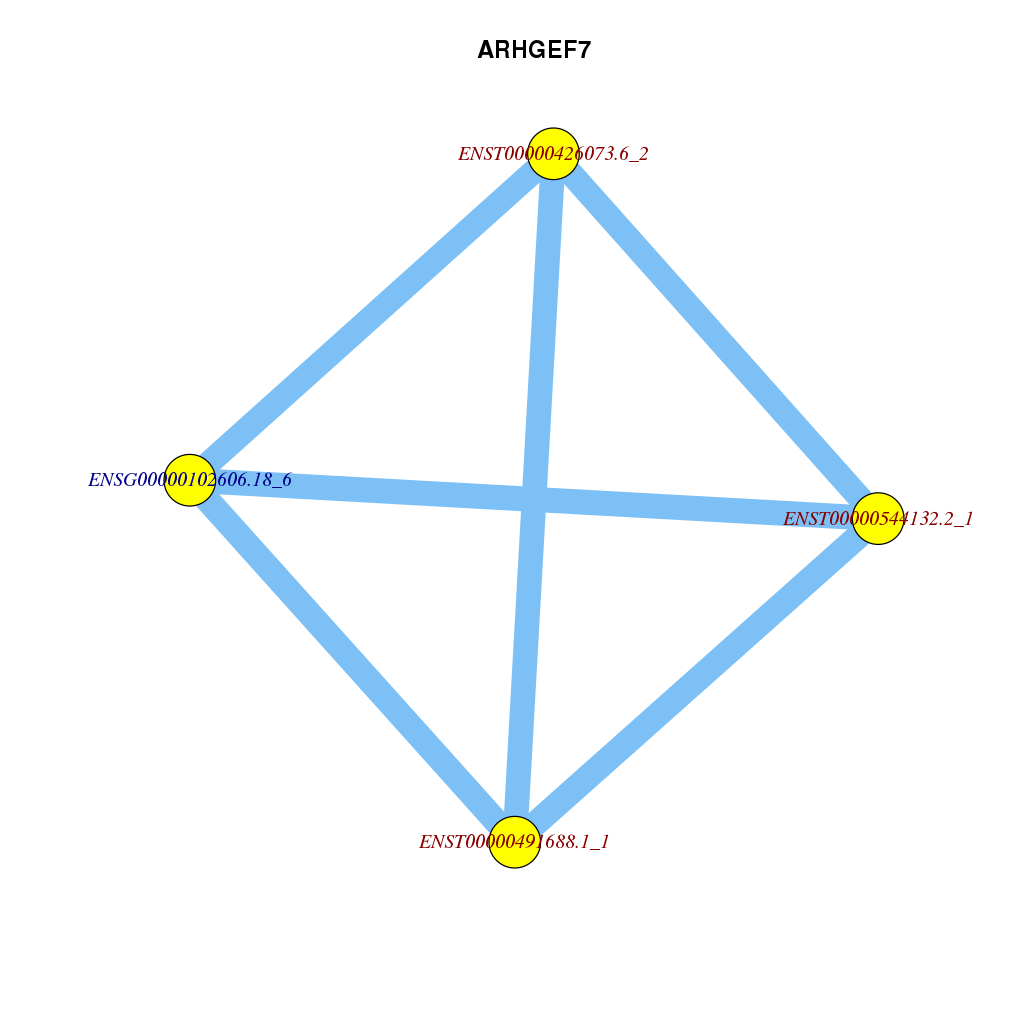

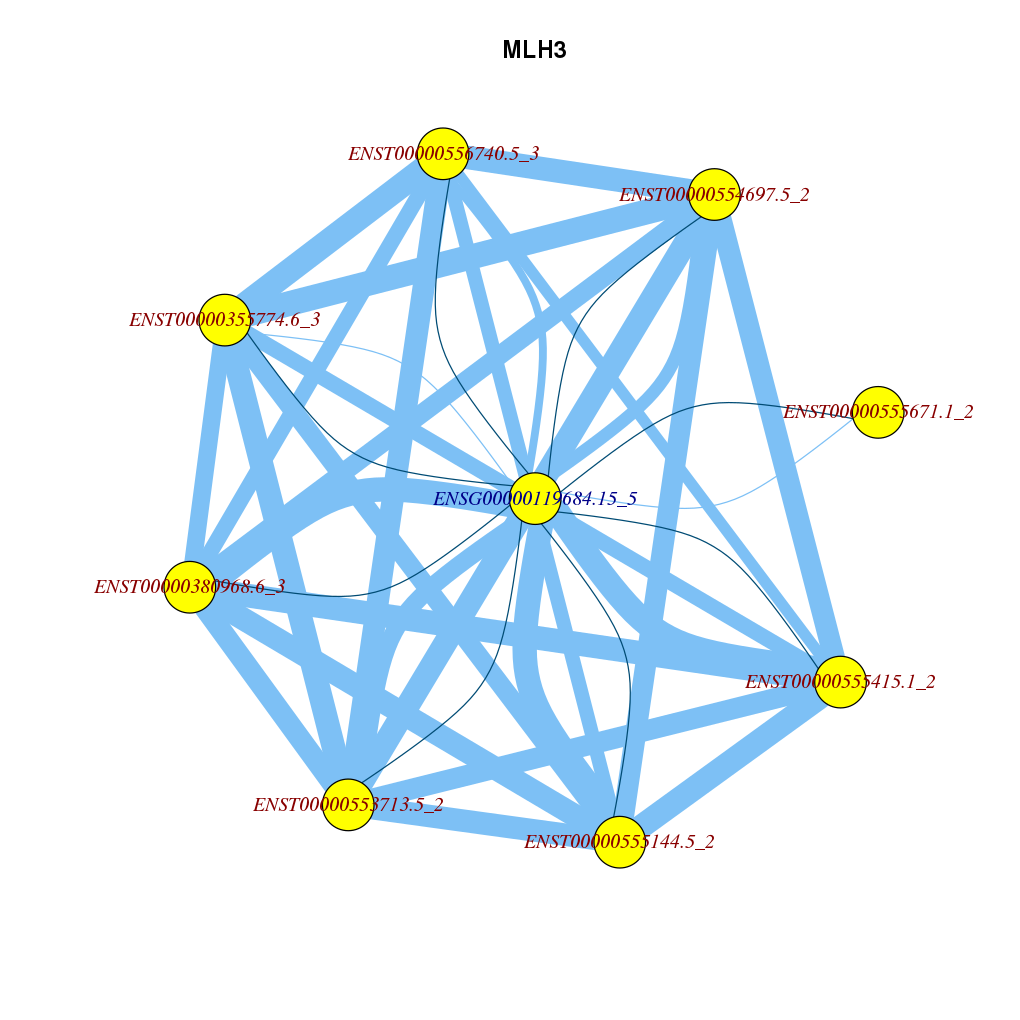

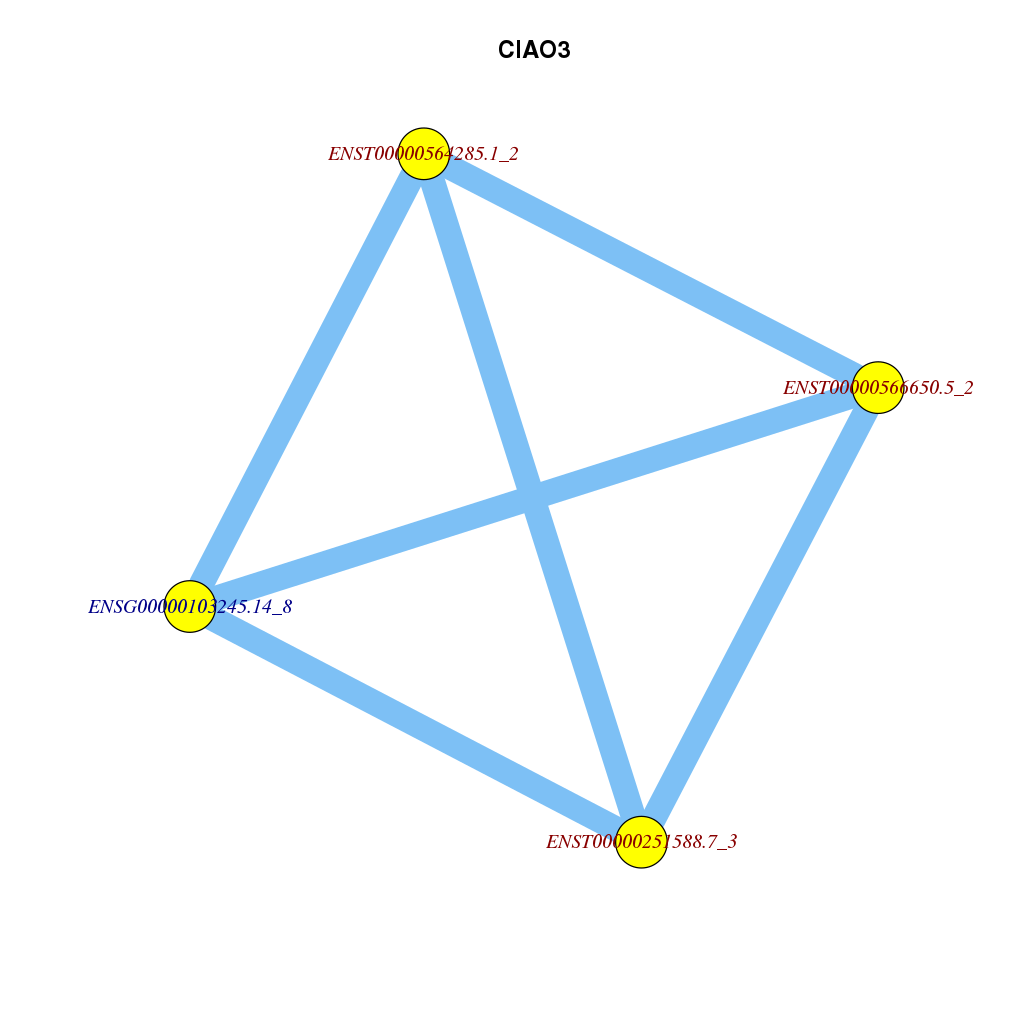

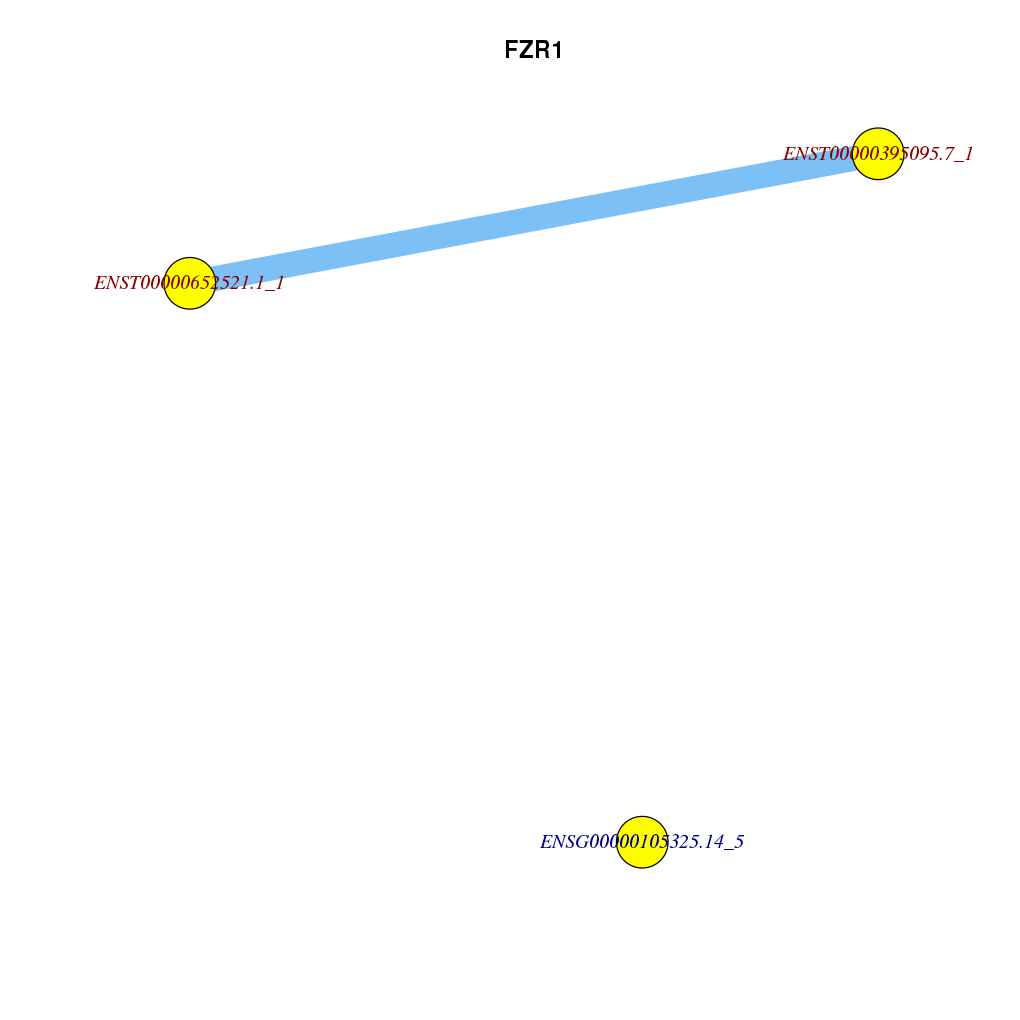

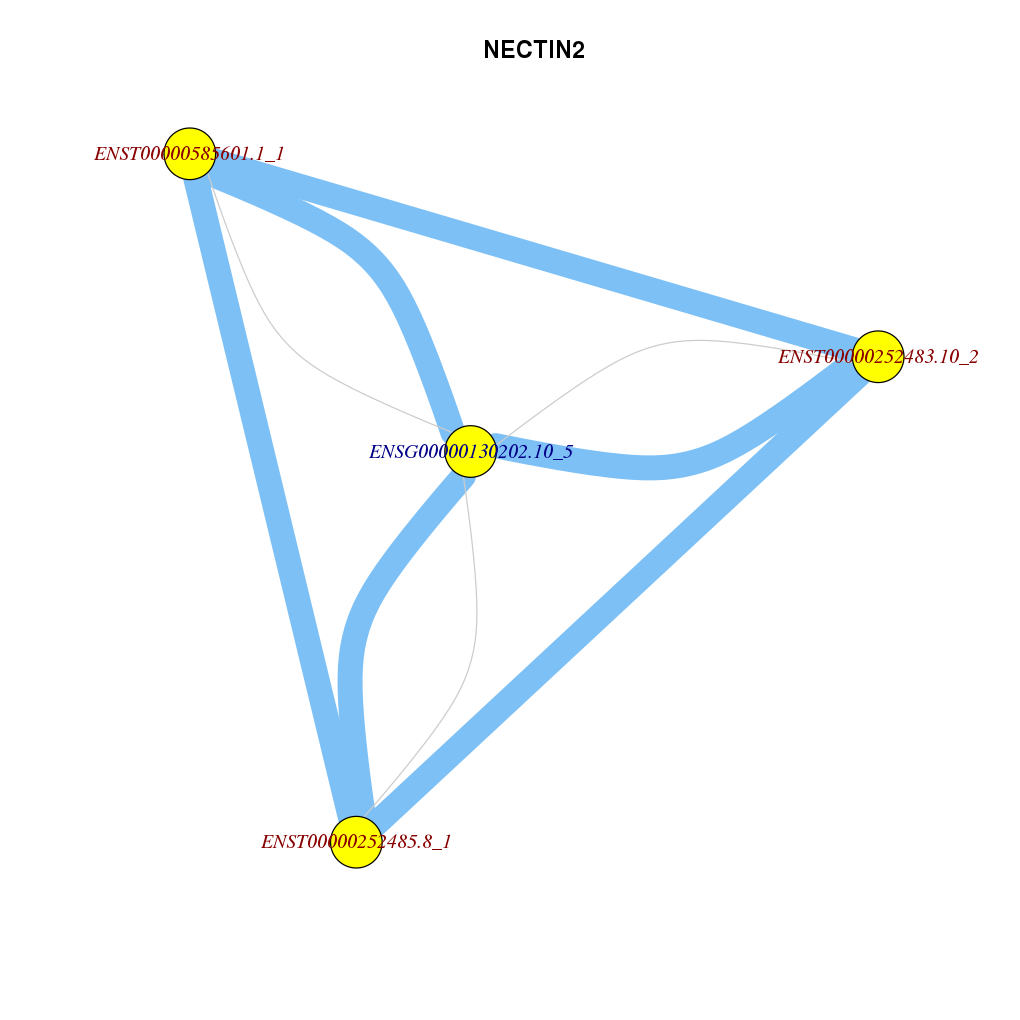

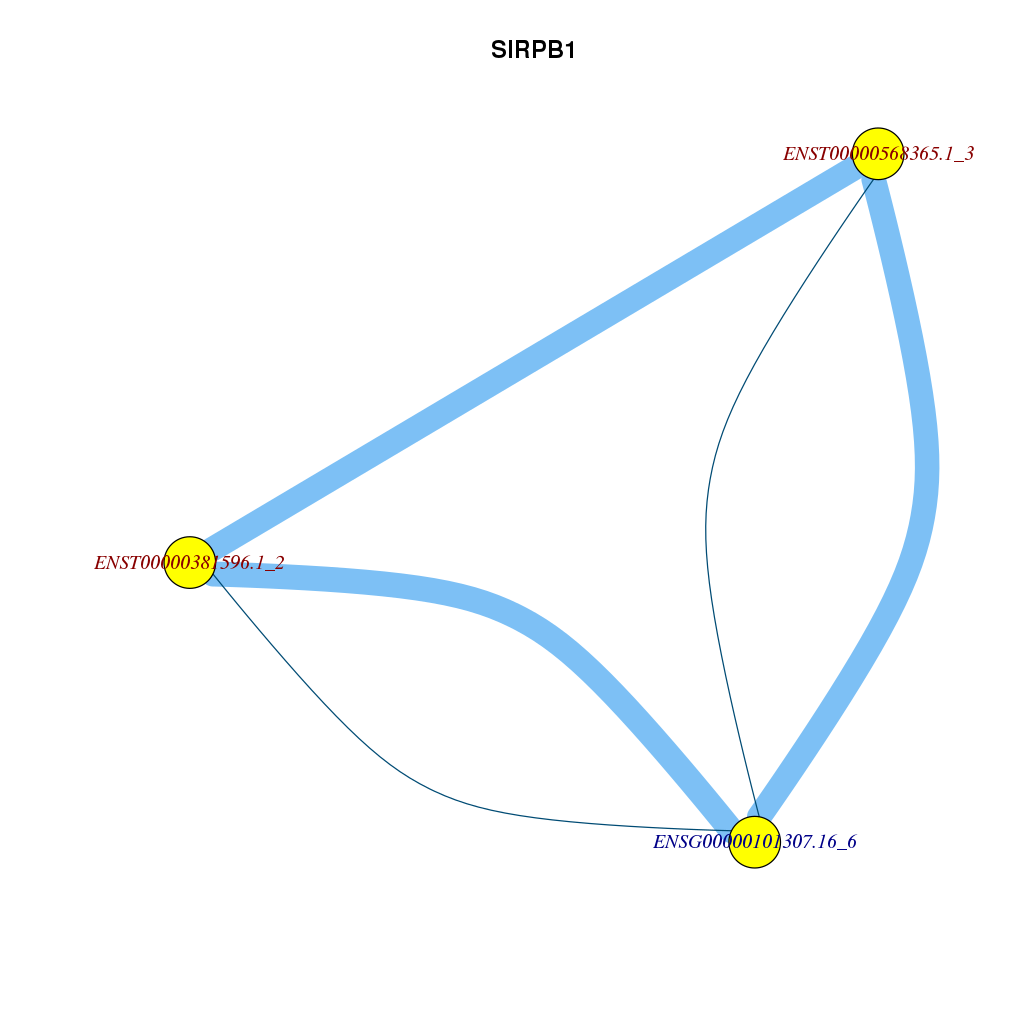

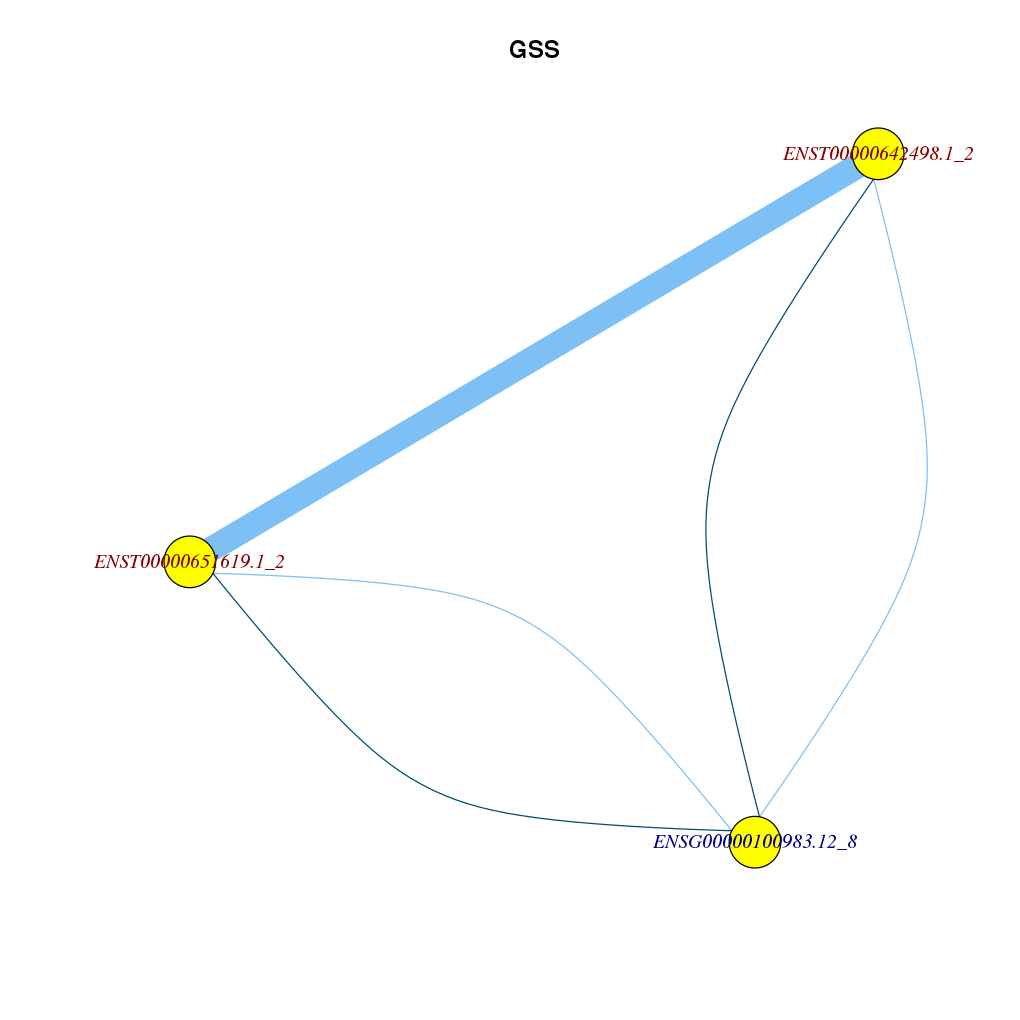

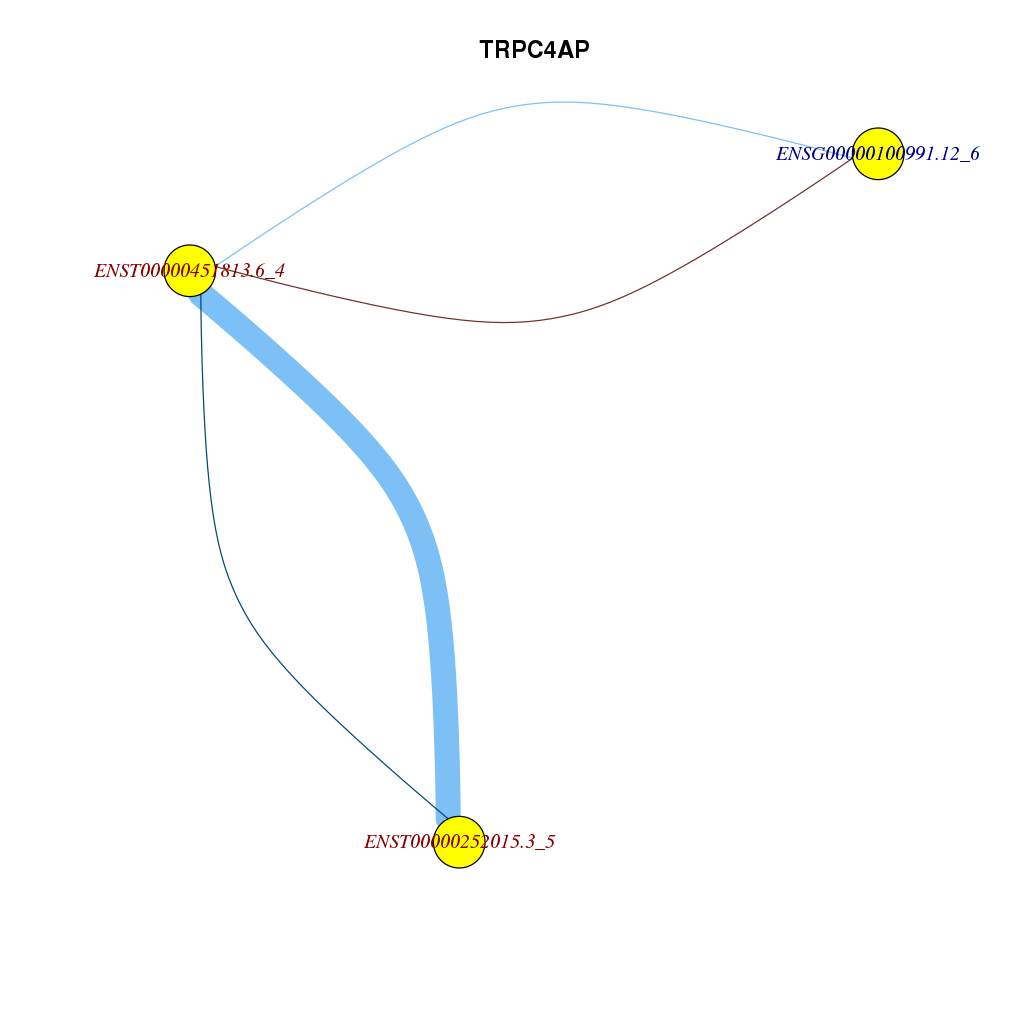

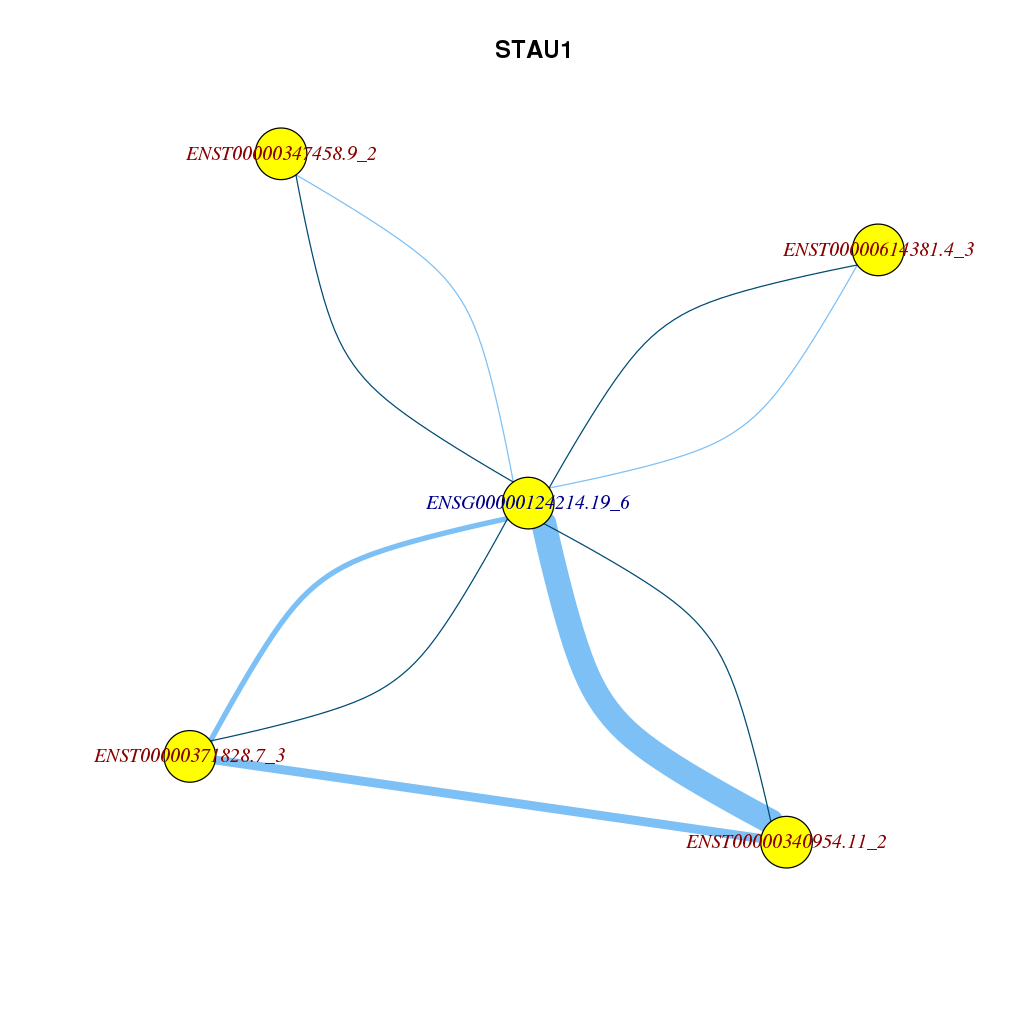

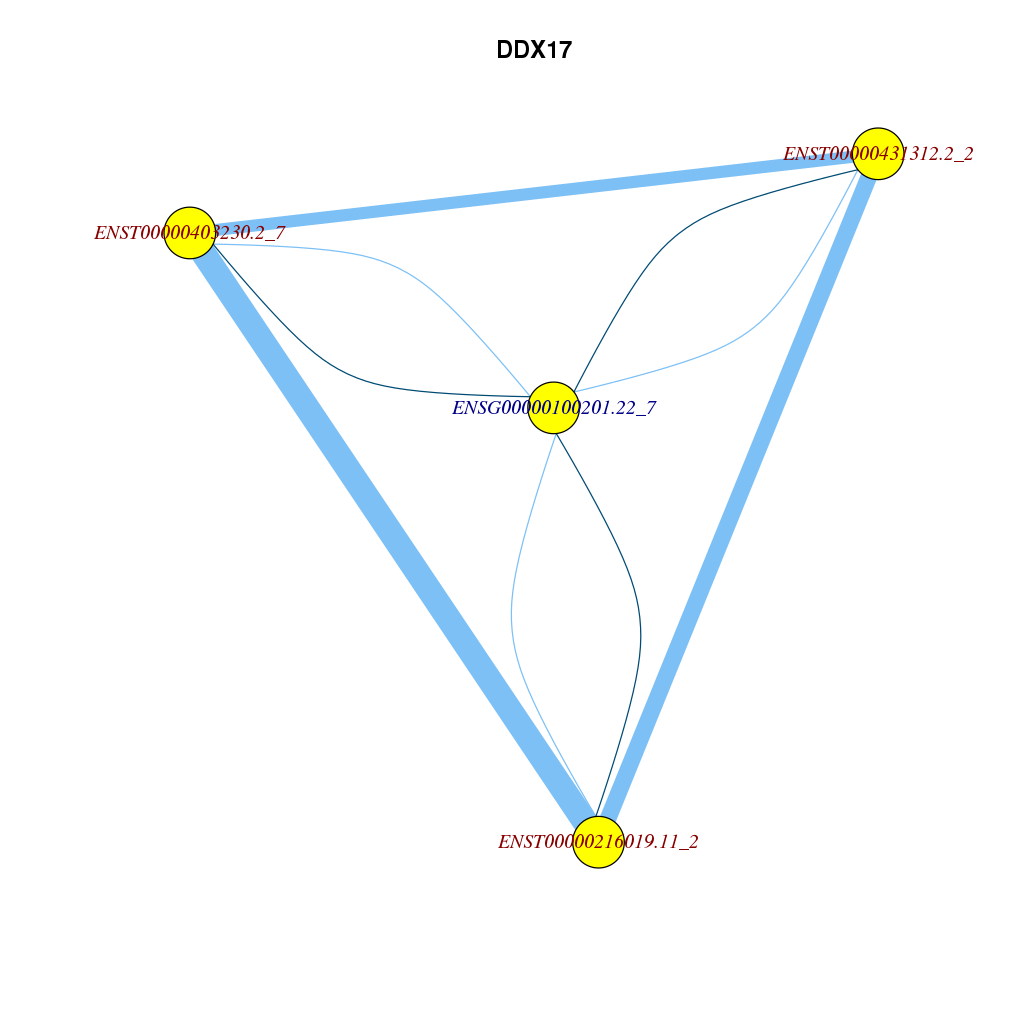

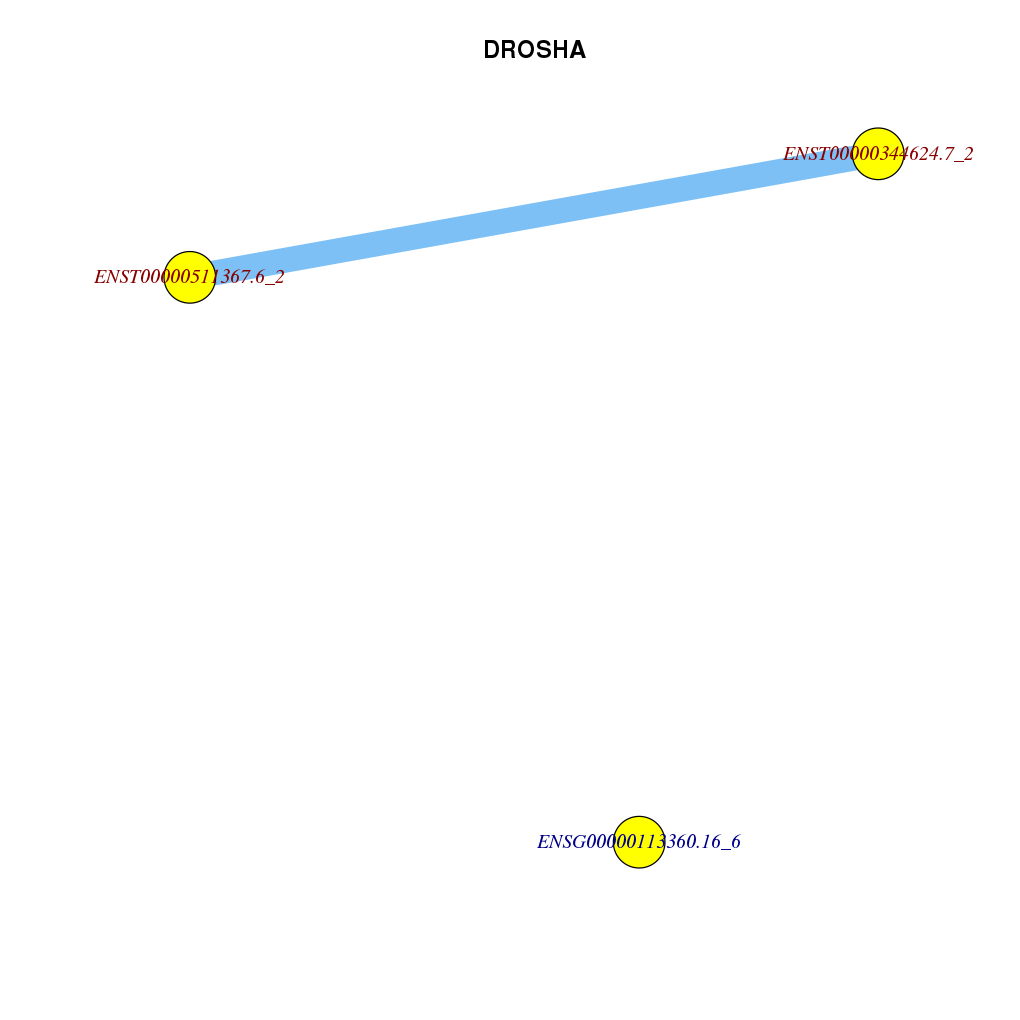

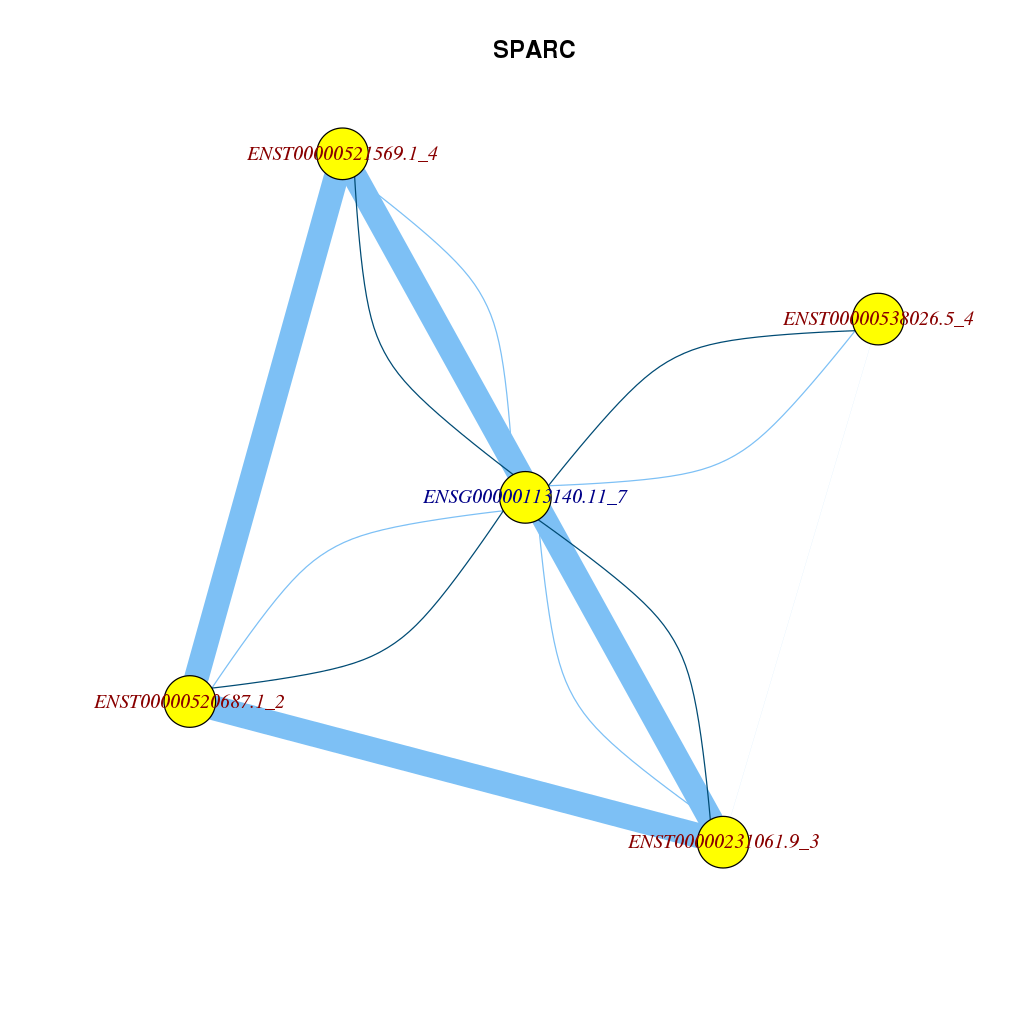

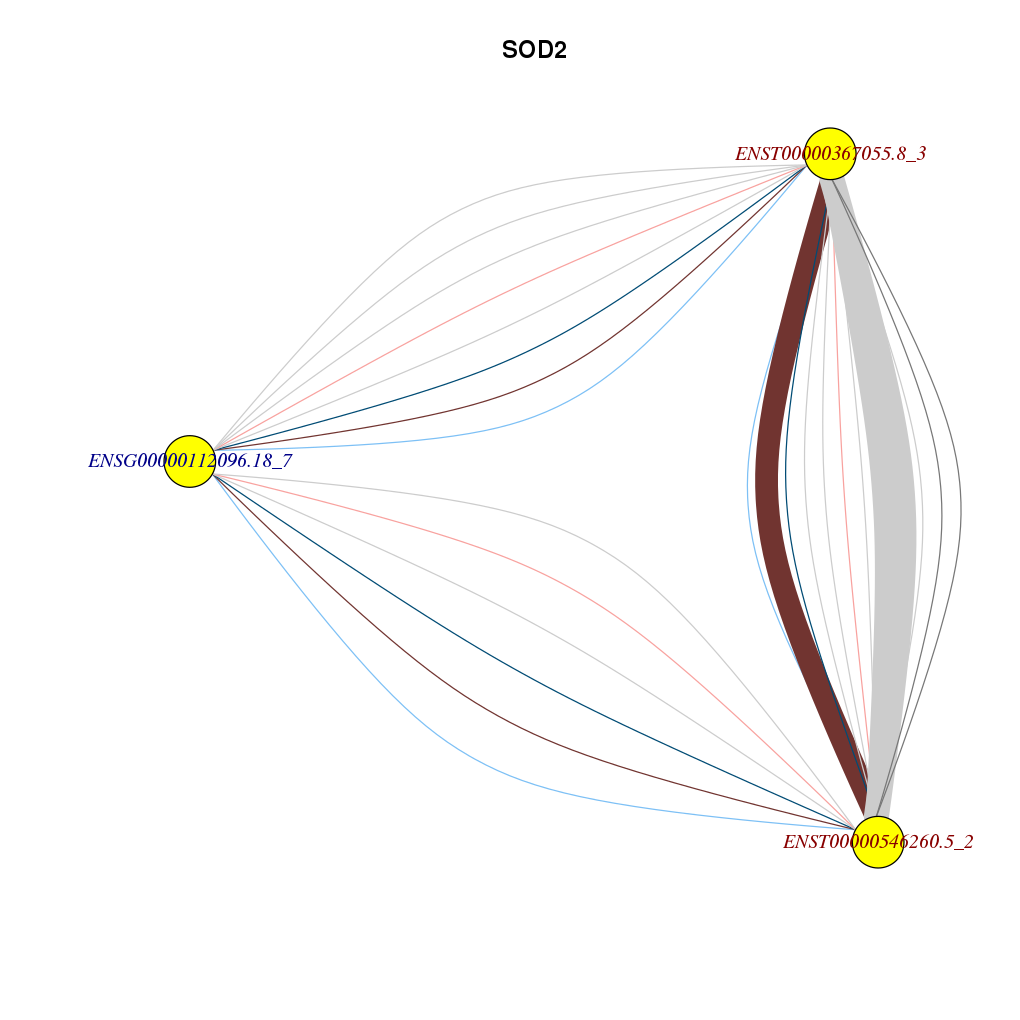

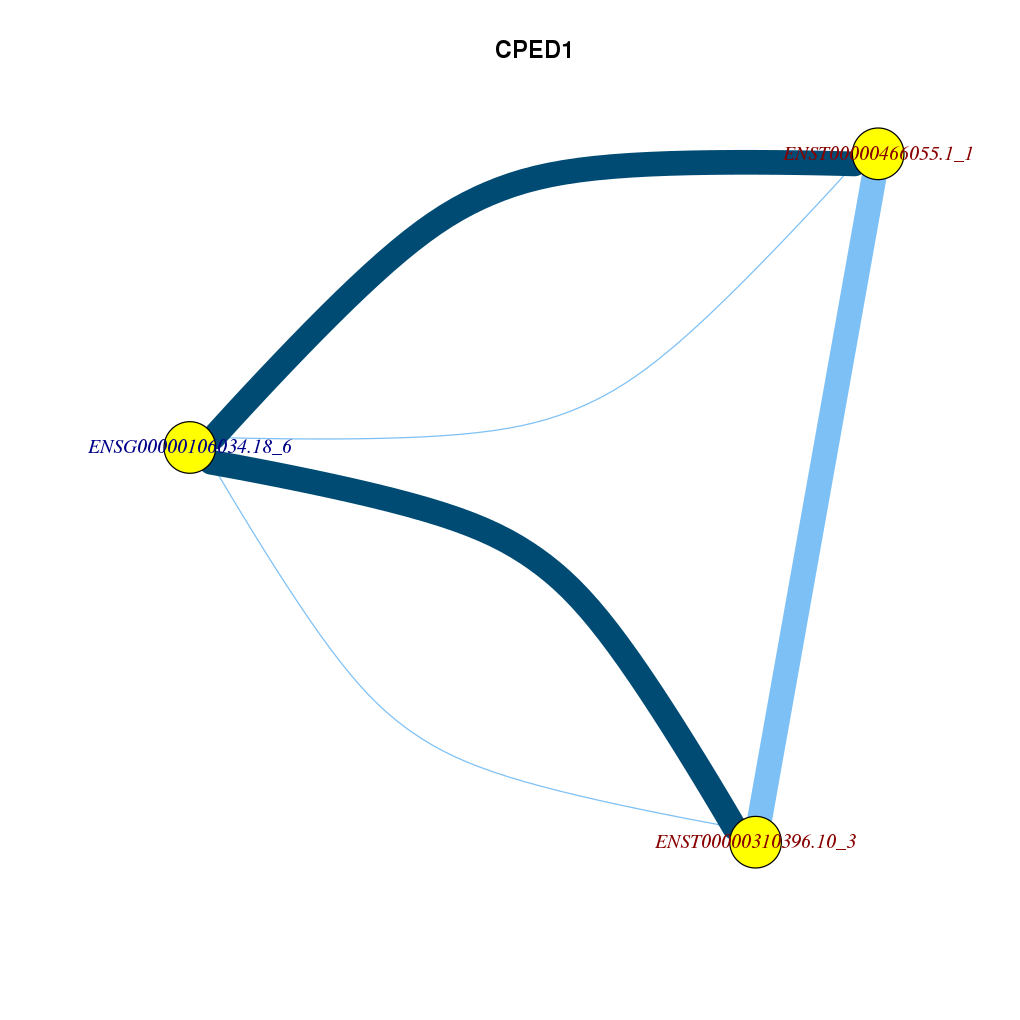

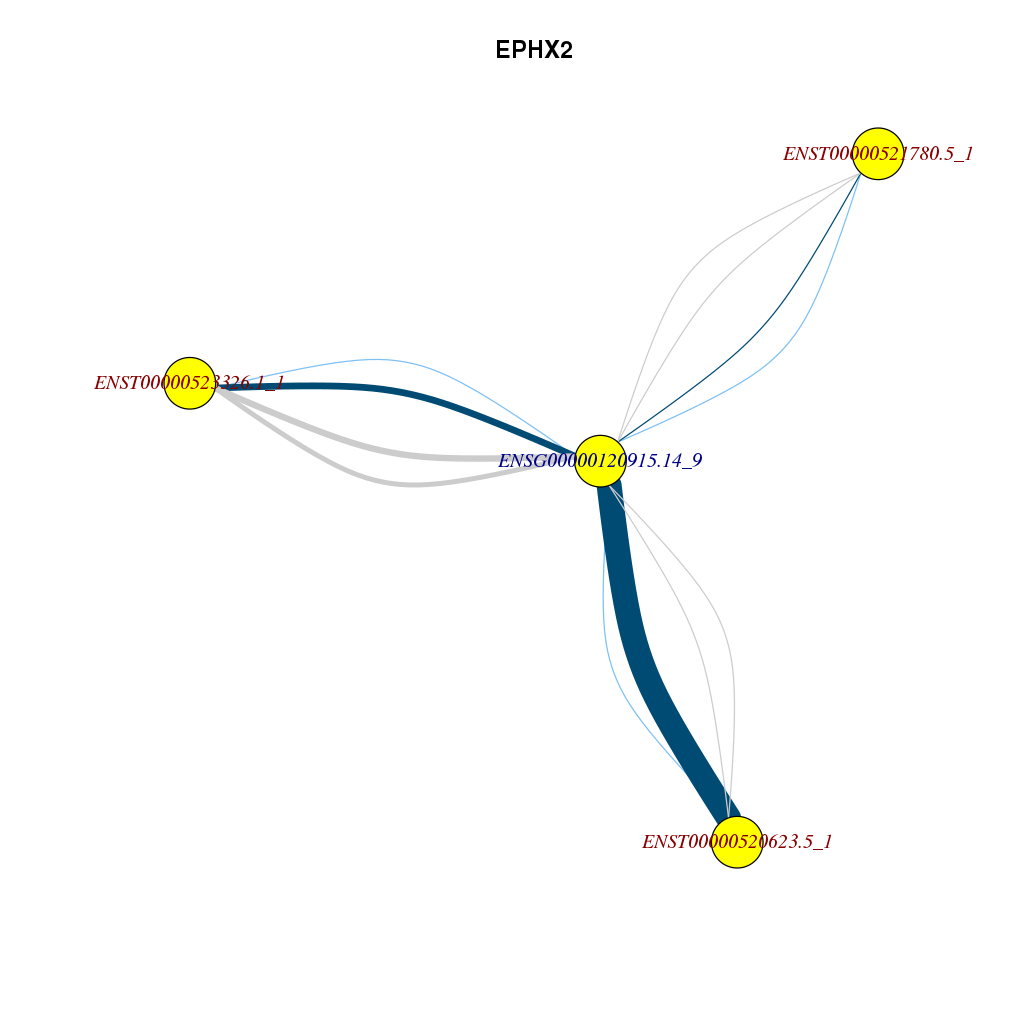

In [428]:
options(repr.plot.width = 8.5, repr.plot.height = 8.5)
invisible(lapply(geneinfo_genes[ geneinfo_genes$gene_name %in% best, "gene_id"], function(gene_id){try(net_iso(gene_id, coloc, eqtl_genes, eqtl_isoforms))}))


# Interaction between eGenes and eIsoform - cell and tissue

In [440]:
toint = rbind(ints_genes   [ints_genes   $cell == TRUE, c("transcript_id", "type", "interaction")], 
              ints_isoforms[ints_isoforms$cell == TRUE, c("transcript_id", "type", "interaction")]
             )
coloc2int = coloc
coloc2int$tr2type1 = paste(coloc2int$transcript_id1, coloc2int$type1)
coloc2int$tr2type2 = paste(coloc2int$transcript_id2, coloc2int$type2)
toint    $tr2type  = paste(toint    $transcript_id , toint    $type )

coloc2int          = merge(coloc2int, toint[,c("tr2type", "interaction")], by.x = "tr2type1", by.y = "tr2type", all.x = TRUE)
coloc2int          = merge(coloc2int, toint[,c("tr2type", "interaction")], by.x = "tr2type2", by.y = "tr2type", all.x = TRUE, suffixes = 1:2)


In [441]:
str(coloc2int)

'data.frame':	33098 obs. of  26 variables:
 $ tr2type2      : chr  "ENSG00000000419.12_6 0" "ENSG00000000457.14_7 0" "ENSG00000000971.16_4 0" "ENSG00000000971.16_4 0" ...
 $ tr2type1      : chr  "ENST00000371588.9_2 0" "ENST00000367771.11_4 0" "ENST00000367429.9_2 0" "ENST00000630130.2_1 0" ...
 $ transcript_id1: chr  "ENST00000371588.9_2" "ENST00000367771.11_4" "ENST00000367429.9_2" "ENST00000630130.2_1" ...
 $ nsnps         : int  2011 2835 1293 1293 2493 2493 2493 2493 1957 1957 ...
 $ PP.H0.abf     : num  3.94e-01 1.09e-02 1.26e-06 1.87e-07 4.94e-19 ...
 $ PP.H1.abf     : num  4.80e-01 3.02e-01 3.59e-05 3.70e-05 2.97e-09 ...
 $ PP.H2.abf     : num  4.72e-02 2.10e-02 3.40e-02 5.03e-03 1.07e-12 ...
 $ PP.H3.abf     : num  0.05758 0.58199 0.96493 0.99436 0.00545 ...
 $ PP.H4.abf     : num  0.021105 0.084104 0.001079 0.000569 0.994552 ...
 $ transcript_id2: chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000971.16_4" "ENSG00000000971.16_4" ...
 $ type1         : int  0 0 0

# Investigate when the isoform and gene don't have the same eQTL
- HYP1: the isoform eQTL affects splicing, so it must be on the transcript (i.e. on the gene body), while the gene doesn't
- HYP2: if the isoform eQTL is in the gene body, then it should not be cell type-associated, as other things regulate its expression

## Hyp 1

In [396]:
eqtl_genes   $tr2type = paste(eqtl_genes   $transcript_id, eqtl_genes   $type)
eqtl_isoforms$tr2type = paste(eqtl_isoforms$transcript_id, eqtl_isoforms$type)


In [481]:
tosp          = coloc[coloc$transcript_id2 == coloc$gene_id,]
tosp$tr2type1 = paste(tosp$transcript_id1, tosp$type1)
tosp$tr2type2 = paste(tosp$transcript_id2, tosp$type2)

eqtl_genes2merge           = eqtl_genes
eqtl_genes2merge$id2       = eqtl_genes2merge$id
eqtl_genes2merge$pos2      = eqtl_genes2merge$pos
eqtl_genes2merge$distance2 = eqtl_genes2merge$distance

eqtl_isoforms2merge           = eqtl_isoforms
eqtl_isoforms2merge$id1       = eqtl_isoforms2merge$id
eqtl_isoforms2merge$pos1      = eqtl_isoforms2merge$pos
eqtl_isoforms2merge$distance1 = eqtl_isoforms2merge$distance

tosp = merge(tosp, eqtl_isoforms2merge[ eqtl_isoforms2merge$egene == TRUE, c("tr2type", "id1", "pos1", "distance1"                )], by.x = "tr2type1", by.y = "tr2type")
tosp = merge(tosp, eqtl_genes2merge   [ eqtl_genes2merge   $egene == TRUE, c("tr2type", "id2", "pos2", "distance2", "start", "end")], by.x = "tr2type2", by.y = "tr2type")

tosp$in1 = FALSE
tosp$in2 = FALSE

tosp[tosp$pos1 >= tosp$start & tosp$pos1 <= tosp$end, "in1"] = TRUE
tosp[tosp$pos2 >= tosp$start & tosp$pos2 <= tosp$end, "in2"] = TRUE



In [480]:
totest_iso = c(nrow(tosp[ tosp$PP.H3.abf >  0.5 & tosp$in1 == TRUE ,]),
               nrow(tosp[ tosp$PP.H3.abf <= 0.5 & tosp$in1 == TRUE ,]),
               nrow(tosp[ tosp$PP.H3.abf >  0.5 & tosp$in1 == FALSE,]),
               nrow(tosp[ tosp$PP.H3.abf <= 0.5 & tosp$in1 == FALSE,])
              ) # are the eIisoforms that do not colocalize with the eGene more likely to be in the gene body than eIsoforms that colocalize with eGene?

matrix(totest_iso , nrow = 2, byrow = TRUE)

fisher.test(matrix(totest_iso , nrow = 2, byrow = TRUE))


3201,3557
3083,3978



	Fisher's Exact Test for Count Data

data:  matrix(totest_iso, nrow = 2, byrow = TRUE)
p-value = 1.314e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.085261 1.242406
sample estimates:
odds ratio 
  1.161146 



	Paired t-test

data:  abs(tosp[tosp$PP.H3.abf > 0.5, "distance1"]) and abs(tosp[tosp$PP.H3.abf > 0.5, "distance2"])
t = -17.635, df = 6283, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -37638.64 -30107.70
sample estimates:
mean of the differences 
              -33873.17 



	Paired t-test

data:  abs(tosp[tosp$PP.H3.abf > 0.5 & tosp$in1 == FALSE, "distance1"]) and abs(tosp[tosp$PP.H3.abf > 0.5 & tosp$in1 == FALSE, "distance2"])
t = -0.44655, df = 3082, p-value = 0.6552
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -7190.839  4523.069
sample estimates:
mean of the differences 
              -1333.885 


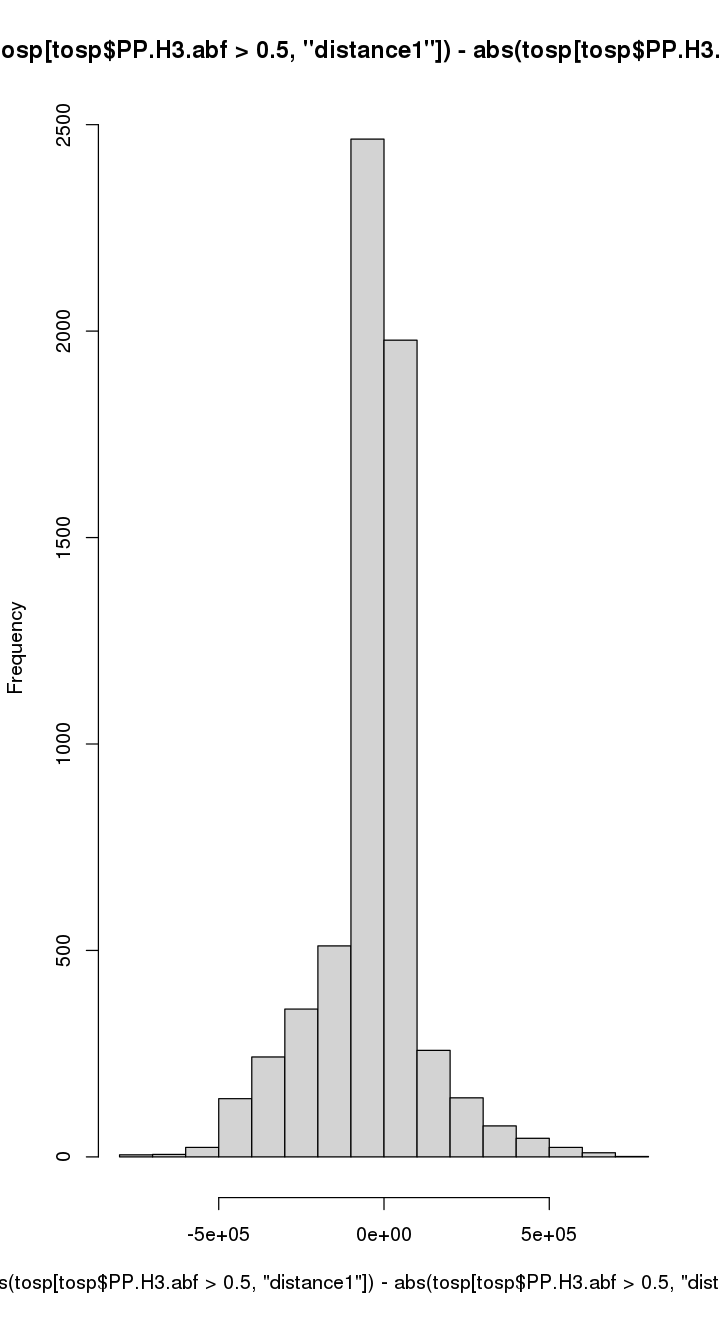

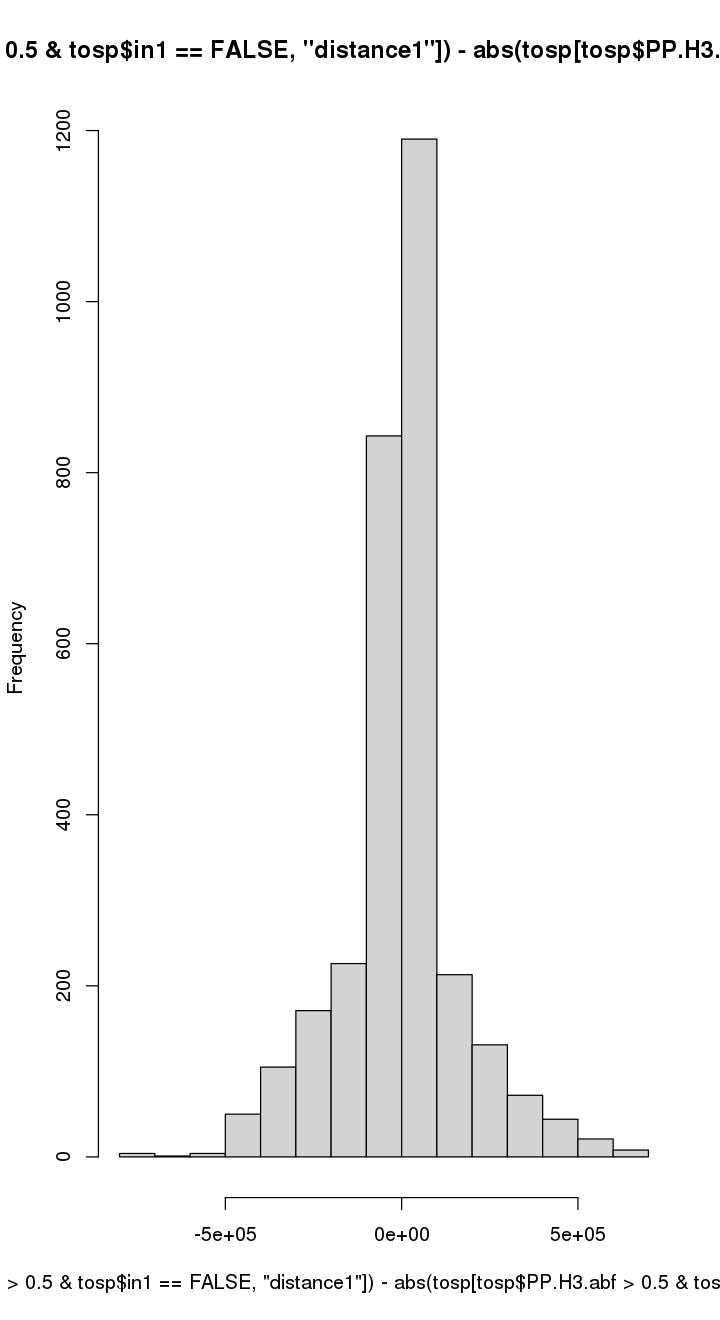

In [488]:
t.test(abs(tosp[ tosp$PP.H3.abf >  0.5, "distance1"]), abs(tosp[ tosp$PP.H3.abf >  0.5, "distance2"]), paired = TRUE)
t.test(abs(tosp[ tosp$PP.H3.abf >  0.5 & tosp$in1 == FALSE, "distance1"]), abs(tosp[ tosp$PP.H3.abf >  0.5 & tosp$in1 == FALSE, "distance2"]), paired = TRUE)

hist(abs(tosp[ tosp$PP.H3.abf >  0.5, "distance1"]) - abs(tosp[ tosp$PP.H3.abf >  0.5, "distance2"]))
hist(abs(tosp[ tosp$PP.H3.abf >  0.5 & tosp$in1 == FALSE, "distance1"]) - abs(tosp[ tosp$PP.H3.abf >  0.5 & tosp$in1 == FALSE, "distance2"]))


## Hyp2: stage

In [18]:
toint           = ints_isoforms[ints_isoforms$cell == TRUE, c("transcript_id", "type", "interaction")]
totest          = eqtl_isoforms
totest$tr2type  = paste(totest$transcript_id, totest$type )
toint $tr2type  = paste(toint $transcript_id, toint $type )
totest$cell     = FALSE
totest$ingene   = FALSE
totest$test     = FALSE

totest[totest$pos >= totest$start & totest$pos <= totest$end                               , "ingene"] = TRUE
totest[totest$ingene == TRUE | (abs(totest$distance) < (totest$end - totest$start))        , "test"  ] = TRUE
totest[totest$tr2type %in% toint[toint$interaction %in% c("ipsc_cvpc", "adult"), "tr2type"], "cell"  ] = TRUE

#totest = totest[totest$test == TRUE,]

totest_c = c(nrow(totest[ totest$cell == TRUE  & totest$ingene == TRUE ,]),
             nrow(totest[ totest$cell == TRUE  & totest$ingene == FALSE,]),
             nrow(totest[ totest$cell == FALSE & totest$ingene == TRUE ,]),
             nrow(totest[ totest$cell == FALSE & totest$ingene == FALSE,])
            )

matrix(totest_c, nrow = 2, byrow = TRUE)

fisher.test(matrix(totest_c, nrow = 2, byrow = TRUE))


128,169
2849,5343



	Fisher's Exact Test for Count Data

data:  matrix(totest_c, nrow = 2, byrow = TRUE)
p-value = 0.003595
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.114775 1.806283
sample estimates:
odds ratio 
  1.420417 


## Hyp2: tissue

In [489]:
toint           = ints_isoforms[ints_isoforms$cell == TRUE, c("transcript_id", "type", "interaction")]
totest          = eqtl_isoforms
totest$tr2type  = paste(totest$transcript_id, totest$type )
toint $tr2type  = paste(toint $transcript_id, toint $type )
totest$cell     = FALSE
totest$ingene   = FALSE
totest$test     = FALSE

totest[totest$ingene == TRUE | (abs(totest$distance) < (totest$end - totest$start))        , "test"  ] = TRUE
totest[totest$tr2type %in% toint[!toint$interaction %in% c("ipsc_cvpc", "adult") & grepl("cibersort", toint$interaction) == FALSE, "tr2type"], "cell"  ] = TRUE
totest[totest$pos >= totest$start & totest$pos <= totest$end                               , "ingene"] = TRUE

#totest = totest[totest$test == TRUE,]

totest_c = c(nrow(totest[ totest$cell == TRUE  & totest$ingene == TRUE ,]),
             nrow(totest[ totest$cell == TRUE  & totest$ingene == FALSE,]),
             nrow(totest[ totest$cell == FALSE & totest$ingene == TRUE ,]),
             nrow(totest[ totest$cell == FALSE & totest$ingene == FALSE,])
            )

matrix(totest_c, nrow = 2, byrow = TRUE)

fisher.test(matrix(totest_c, nrow = 2, byrow = TRUE))


167,216
2773,5321



	Fisher's Exact Test for Count Data

data:  matrix(totest_c, nrow = 2, byrow = TRUE)
p-value = 0.0002255
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.198450 1.833896
sample estimates:
odds ratio 
  1.483545 


## Hyp 2: cell type

In [477]:
toint           = ints_isoforms[ints_isoforms$cell == TRUE, c("transcript_id", "type", "interaction")]
totest          = eqtl_isoforms
totest$tr2type  = paste(totest$transcript_id, totest$type )
toint $tr2type  = paste(toint $transcript_id, toint $type )
totest$cell     = FALSE
totest$ingene   = FALSE
totest$test     = FALSE

totest[totest$ingene == TRUE | (abs(totest$distance) < (totest$end - totest$start))        , "test"  ] = TRUE
totest[totest$tr2type %in% toint[grepl("cibersort", toint$interaction) == TRUE , "tr2type"], "cell"  ] = TRUE
totest[totest$pos >= totest$start & totest$pos <= totest$end                               , "ingene"] = TRUE

#totest = totest[totest$test == TRUE,]

totest_c = c(nrow(totest[ totest$cell == TRUE  & totest$ingene == TRUE ,]),
             nrow(totest[ totest$cell == TRUE  & totest$ingene == FALSE,]),
             nrow(totest[ totest$cell == FALSE & totest$ingene == TRUE ,]),
             nrow(totest[ totest$cell == FALSE & totest$ingene == FALSE,])
            )

matrix(totest_c, nrow = 2, byrow = TRUE)

fisher.test(matrix(totest_c, nrow = 2, byrow = TRUE))


172,219
2768,5318



	Fisher's Exact Test for Count Data

data:  matrix(totest_c, nrow = 2, byrow = TRUE)
p-value = 0.0001074
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.221808 1.861010
sample estimates:
odds ratio 
  1.508898 
